# Gradient Descent

Exploring empirical behavior of gradient descent during training. Some questions of interest are:


- how big is a step?

    - per layer, per neuron, entire network?
    - how does it change over the course of training?
- what do good starting initializations look like?
-  where does the network end up
?
	- ie, how much do the parameters actually shift?

In [1]:
import math

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy

from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Generator

import pandas as pd

In [2]:
# run exploration notebook to get classes -- in the future, might be worth a more elegant solution, like putting custom classes into a distinct .py file

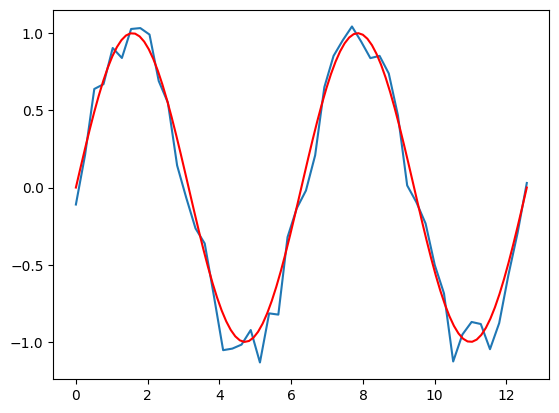

Epoch: 1


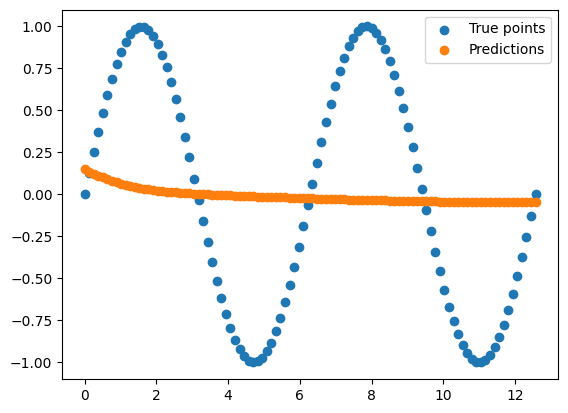

Avg loss: 0.475596 

Epoch: 2


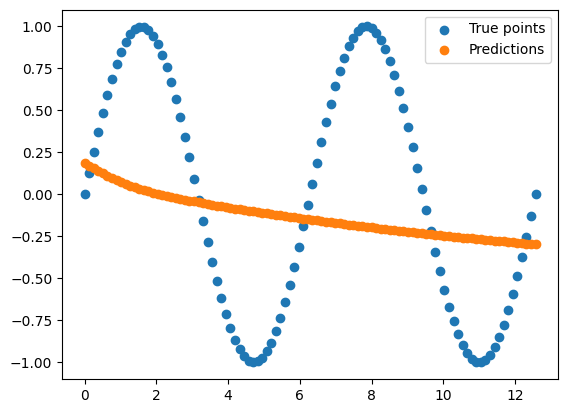

Avg loss: 0.459609 

Epoch: 3


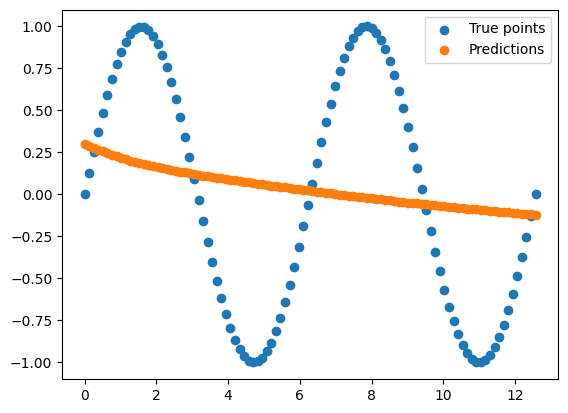

Avg loss: 0.448595 

Epoch: 4


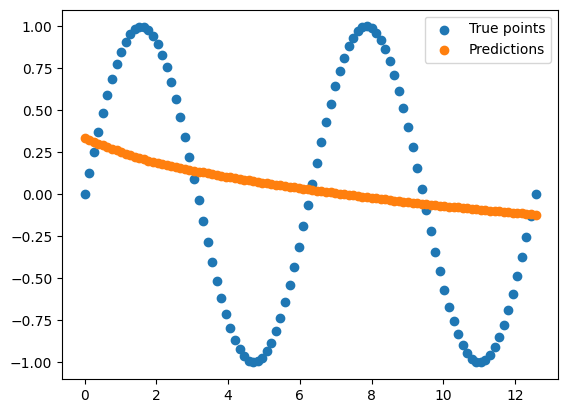

Avg loss: 0.445721 

Epoch: 5


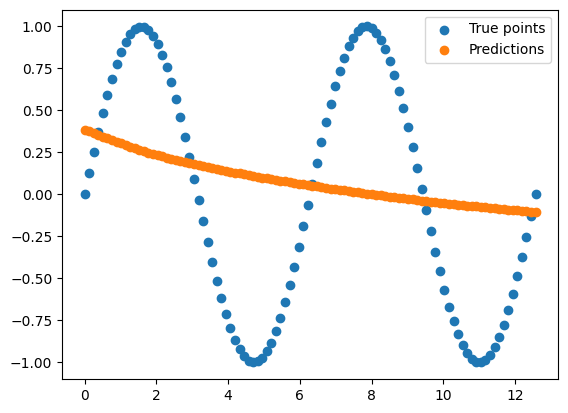

Avg loss: 0.445744 

Epoch: 6


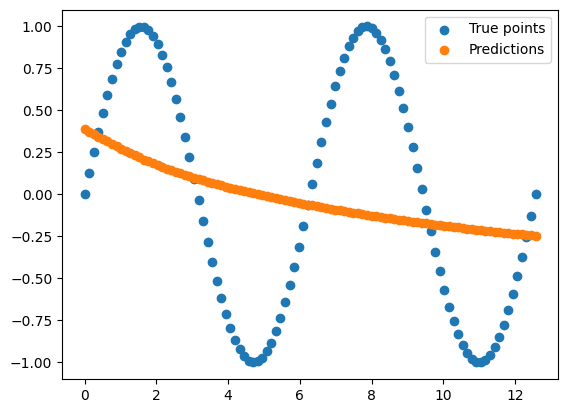

Avg loss: 0.430430 

Epoch: 7


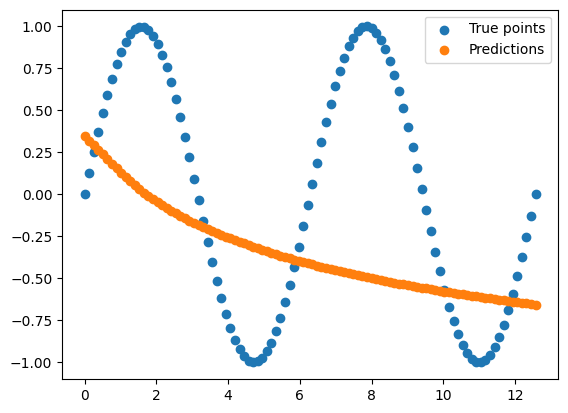

Avg loss: 0.533754 

Epoch: 8


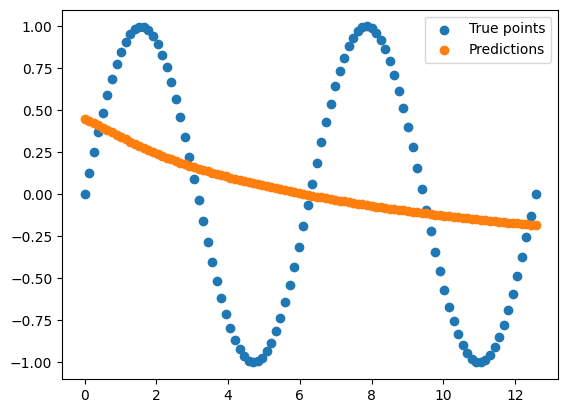

Avg loss: 0.430485 

Epoch: 9


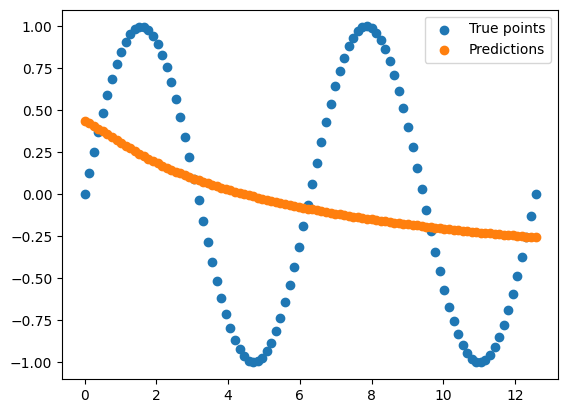

Avg loss: 0.426854 

Epoch: 10


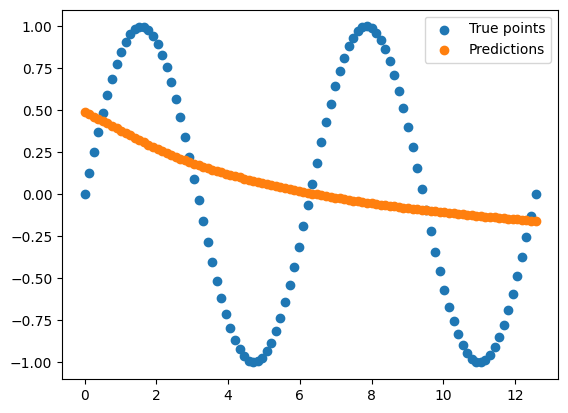

Avg loss: 0.430905 

Epoch: 11


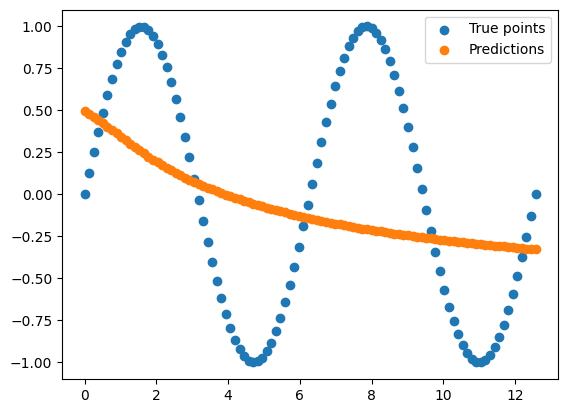

Avg loss: 0.424973 

Epoch: 12


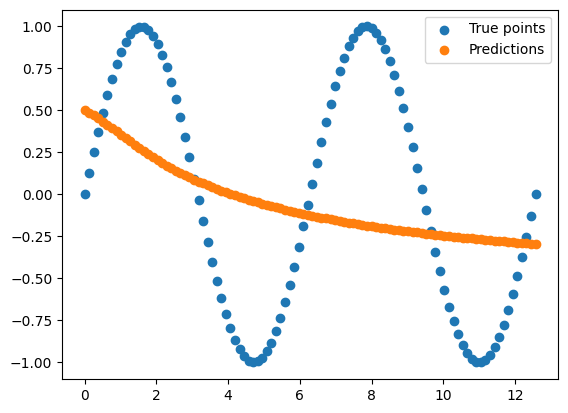

Avg loss: 0.422839 

Epoch: 13


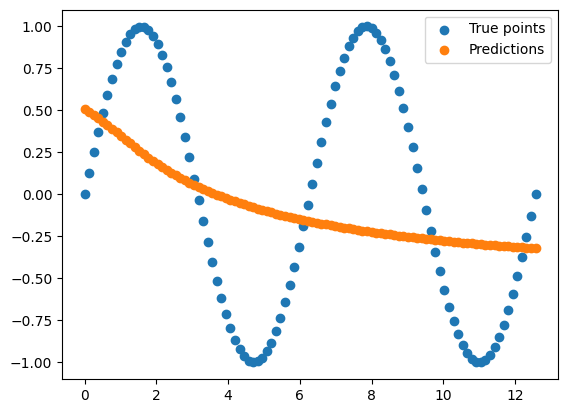

Avg loss: 0.425179 

Epoch: 14


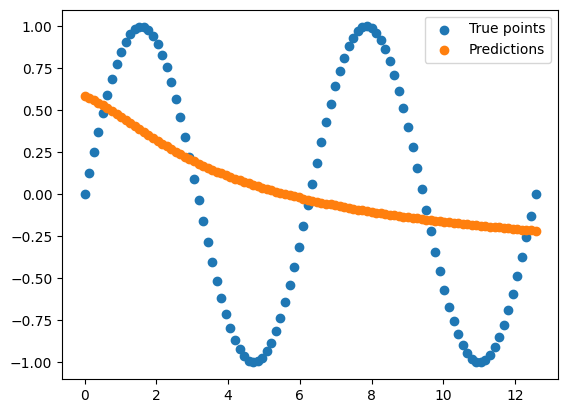

Avg loss: 0.420677 

Epoch: 15


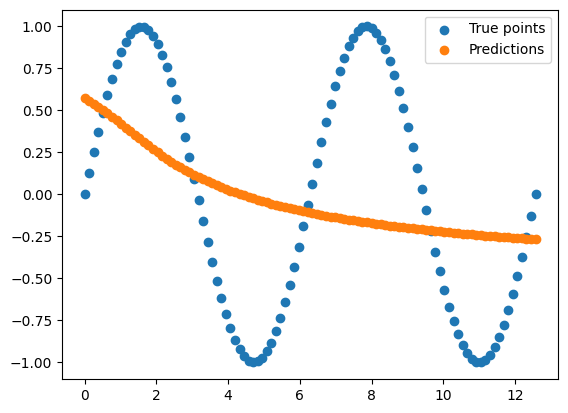

Avg loss: 0.417780 

Epoch: 40


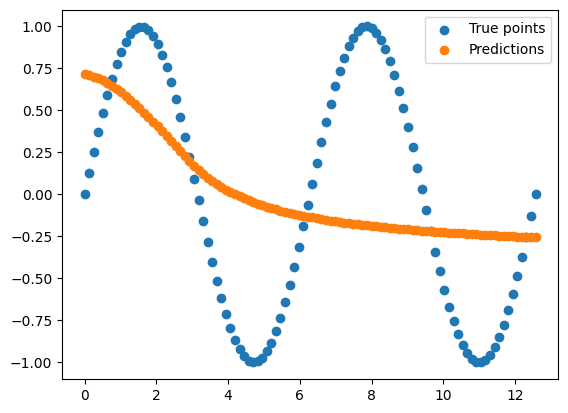

Avg loss: 0.402916 

Epoch: 80


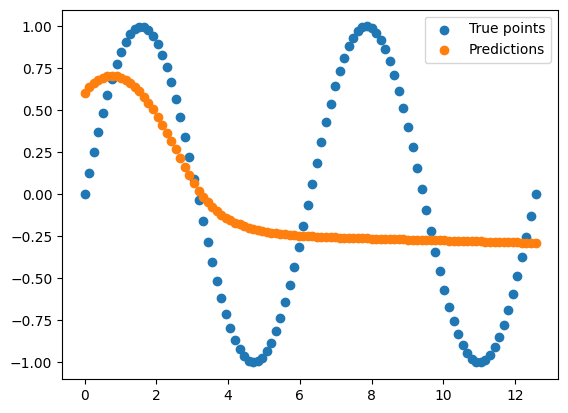

Avg loss: 0.379086 

Epoch: 120


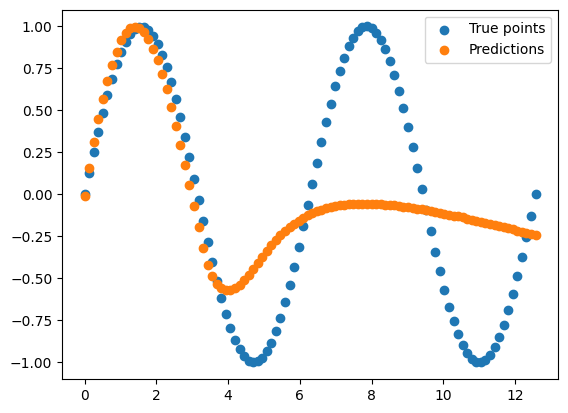

Avg loss: 0.262945 

Epoch: 160


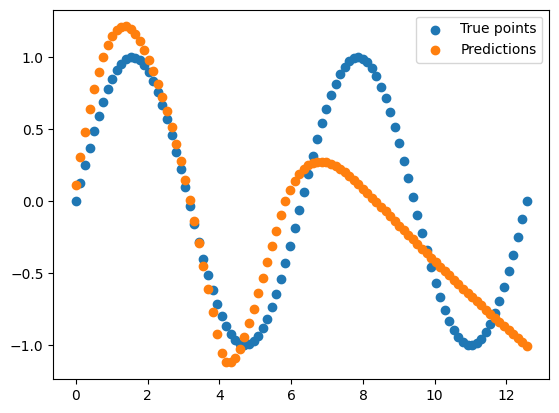

Avg loss: 0.168000 

Epoch: 200


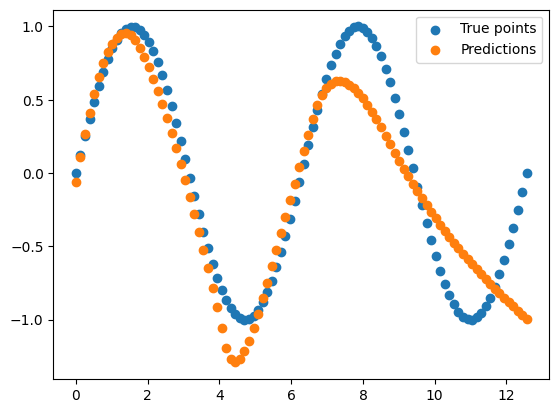

Avg loss: 0.081429 

Done!
Epoch: 1


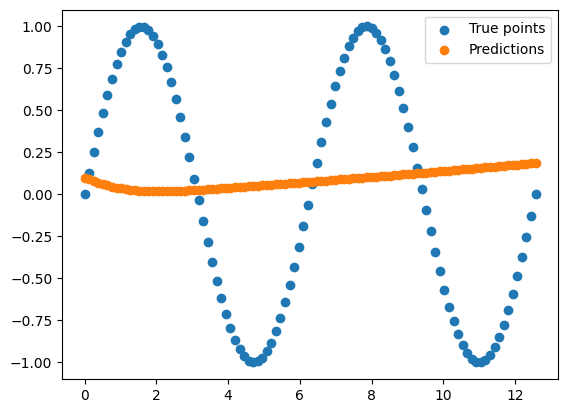

Avg loss: 0.528997 

Epoch: 2


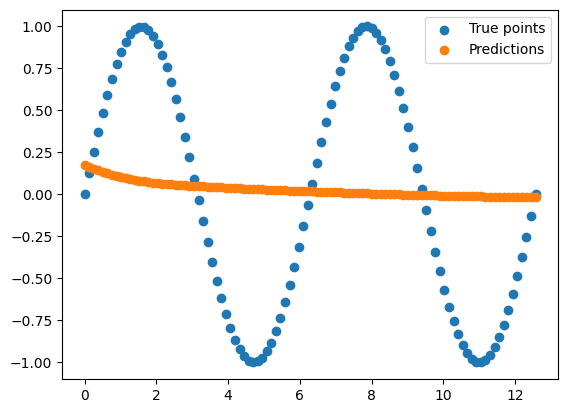

Avg loss: 0.475268 

Epoch: 3


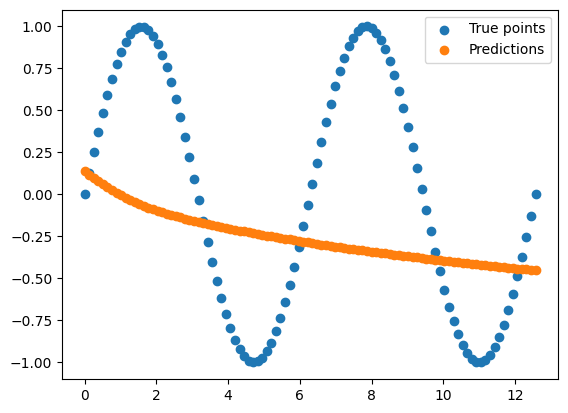

Avg loss: 0.501017 

Epoch: 4


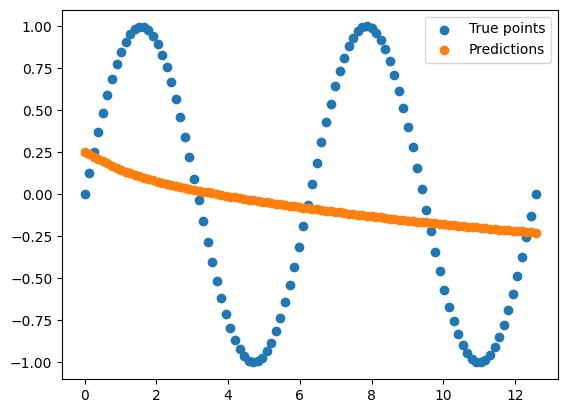

Avg loss: 0.446093 

Epoch: 5


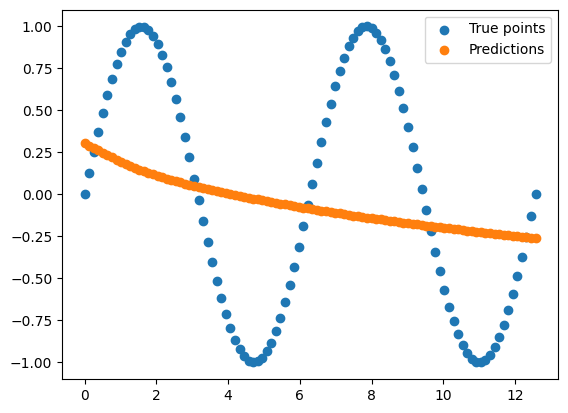

Avg loss: 0.438379 

Epoch: 6


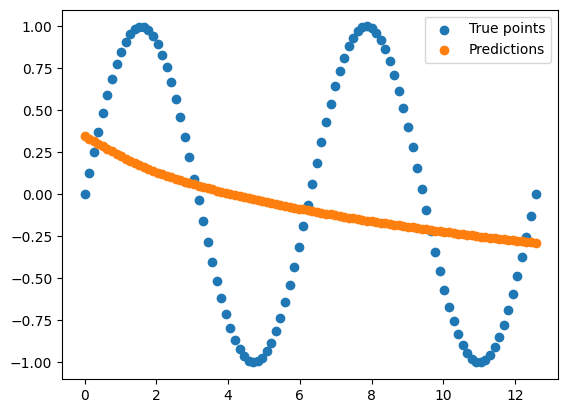

Avg loss: 0.433954 

Epoch: 7


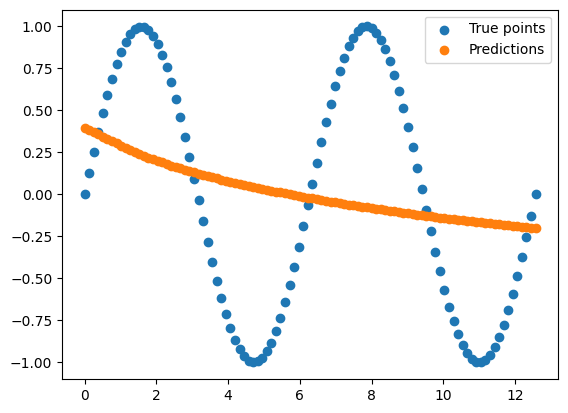

Avg loss: 0.431913 

Epoch: 8


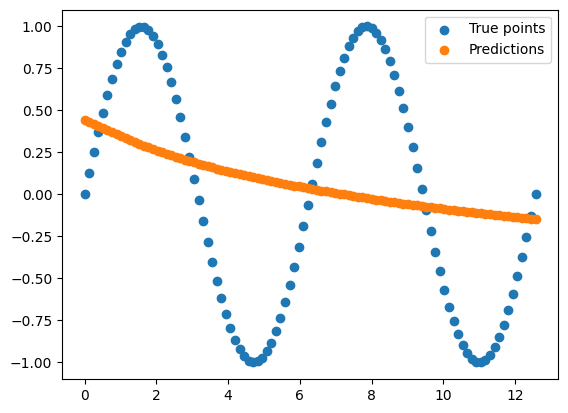

Avg loss: 0.436261 

Epoch: 9


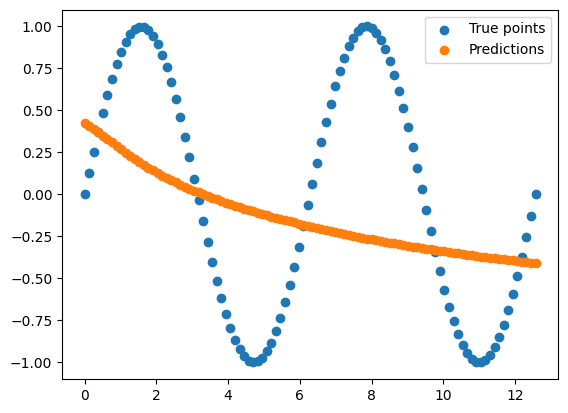

Avg loss: 0.437990 

Epoch: 10


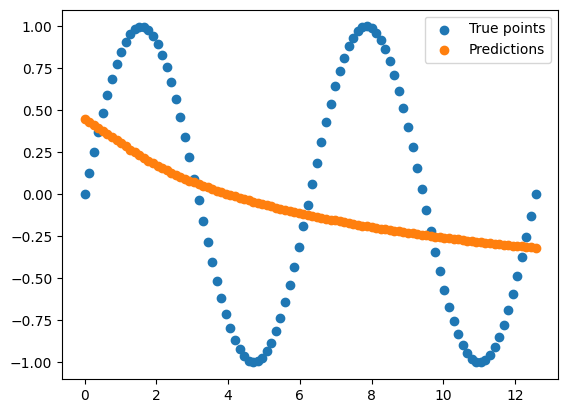

Avg loss: 0.427300 

Epoch: 11


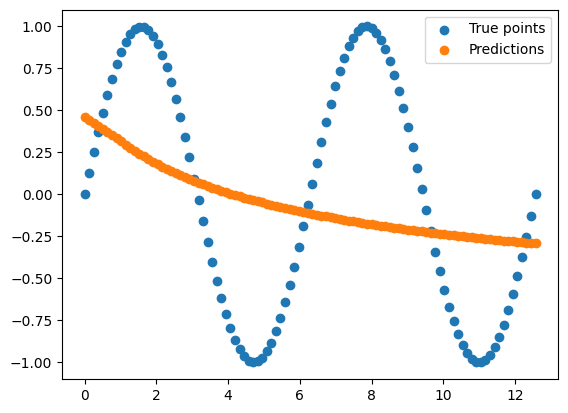

Avg loss: 0.425817 

Epoch: 12


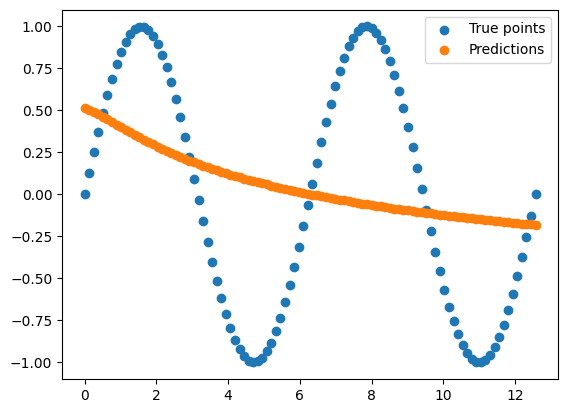

Avg loss: 0.427467 

Epoch: 13


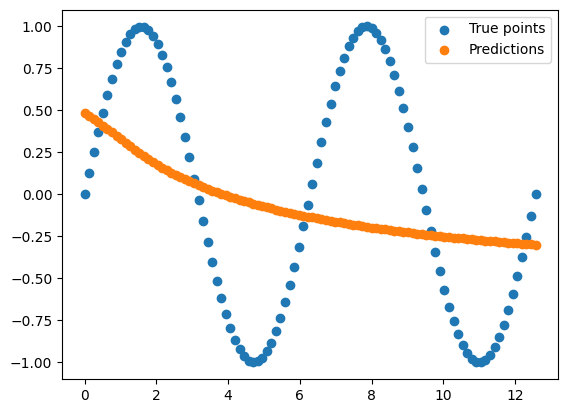

Avg loss: 0.425620 

Epoch: 14


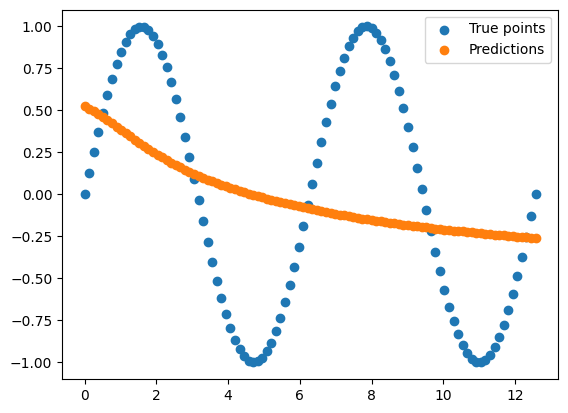

Avg loss: 0.420716 

Epoch: 15


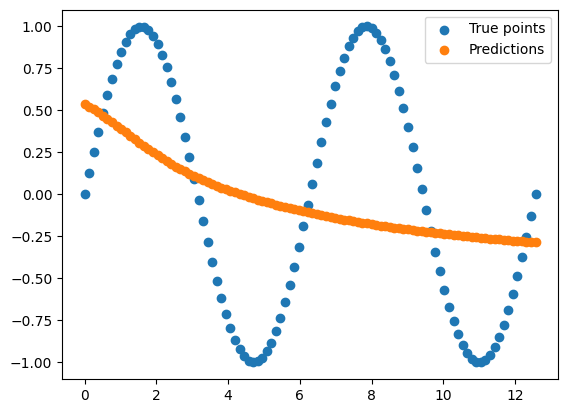

Avg loss: 0.419989 

Epoch: 40


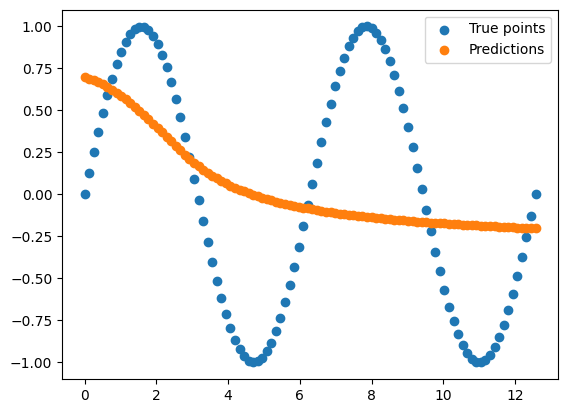

Avg loss: 0.407480 

Epoch: 80


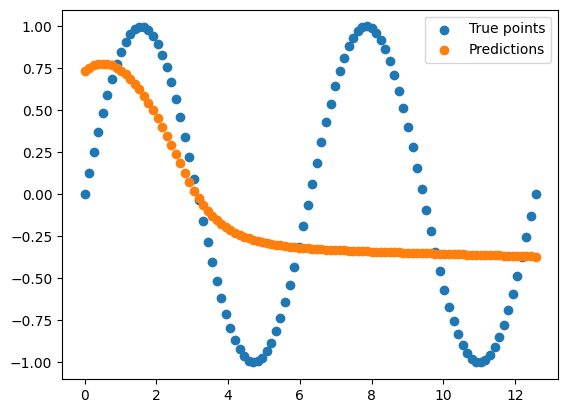

Avg loss: 0.394977 

Epoch: 120


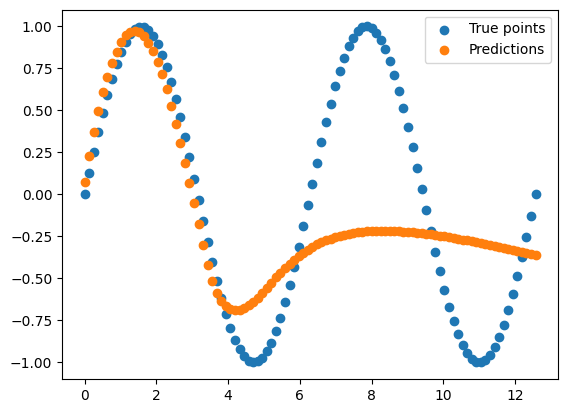

Avg loss: 0.281904 

Epoch: 160


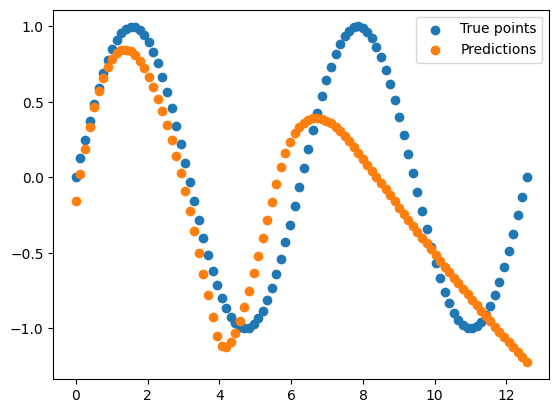

Avg loss: 0.190751 

Epoch: 200


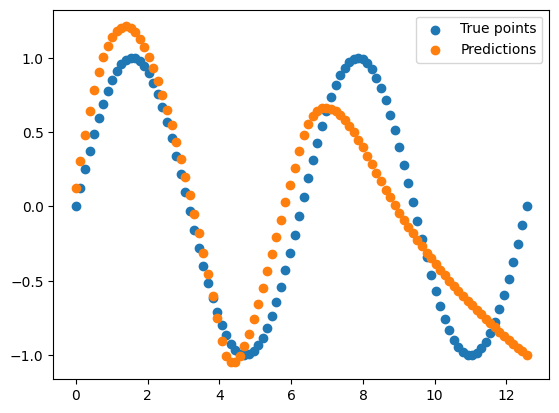

Avg loss: 0.115596 

Done!
Norm of untrained model: 4.678451426683393
Norm of trained standard model: 6.634418153914455
Norm of trained preconditioned model: 6.62768804588275
Residual from preconditioning: 0.4045222707349773
Residual between trained models: 0.8925574595565333


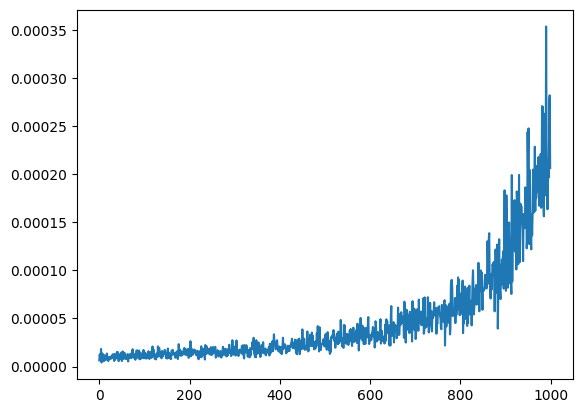

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 40
Epoch: 80
Epoch: 120
Epoch: 160
Epoch: 200
Done!


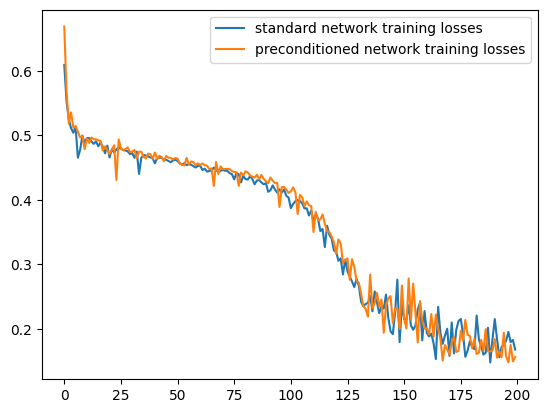

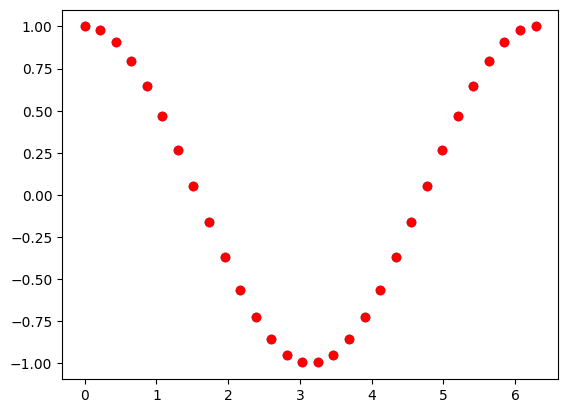

Epoch: 1


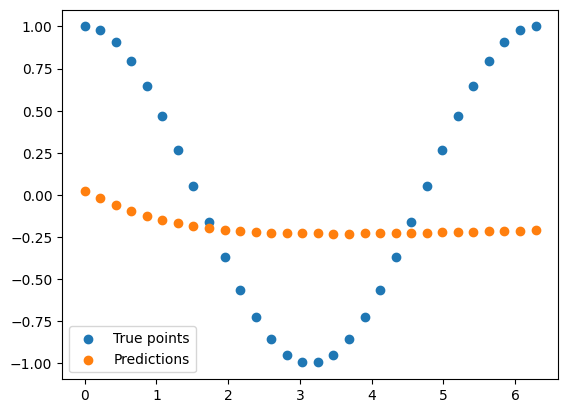

Avg loss: 0.512347 

Epoch: 2


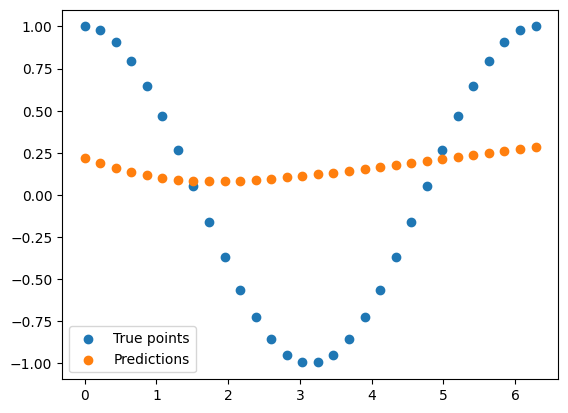

Avg loss: 0.479278 

Epoch: 3


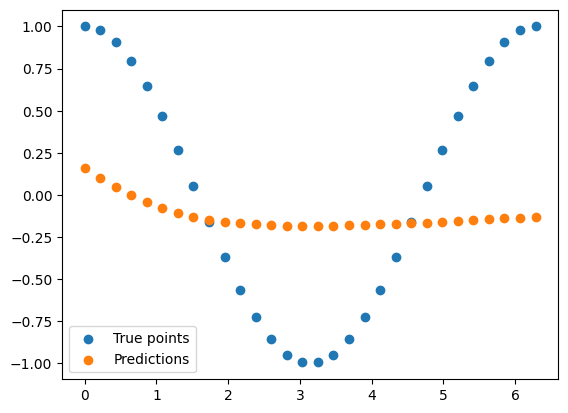

Avg loss: 0.463919 

Epoch: 4


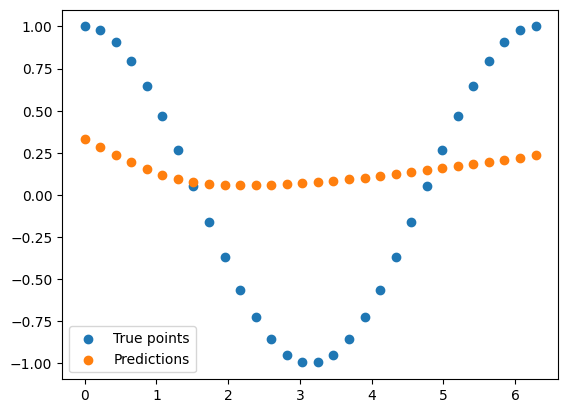

Avg loss: 0.442329 

Epoch: 5


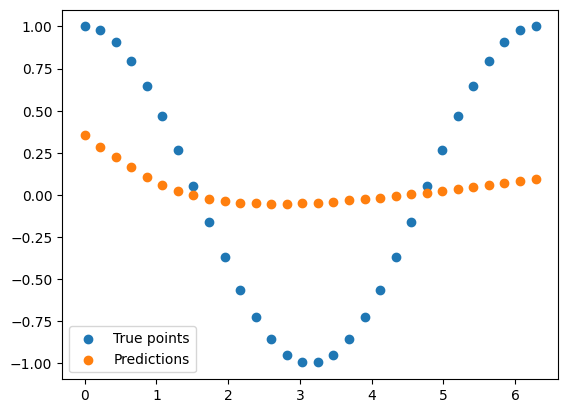

Avg loss: 0.410608 

Epoch: 6


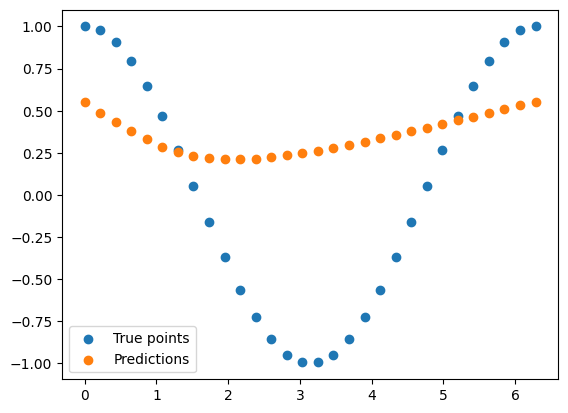

Avg loss: 0.501244 

Epoch: 7


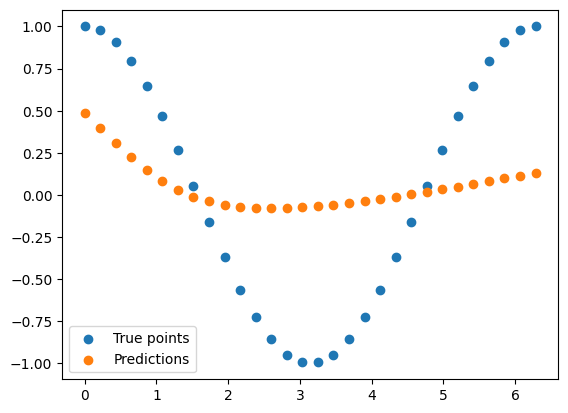

Avg loss: 0.373314 

Epoch: 8


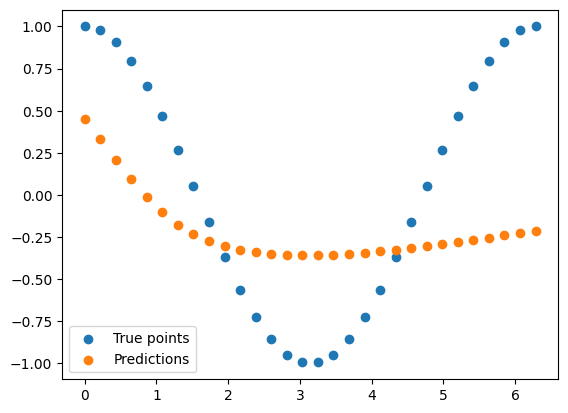

Avg loss: 0.412551 

Epoch: 9


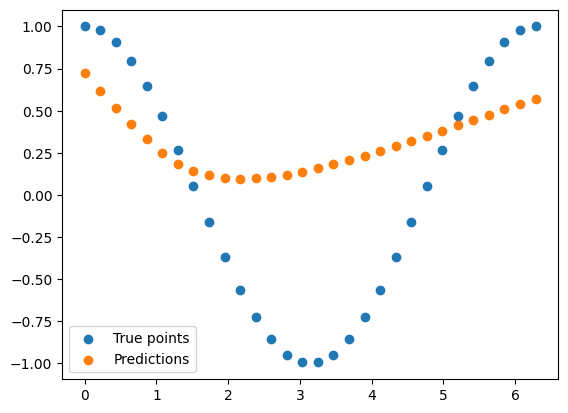

Avg loss: 0.406711 

Epoch: 10


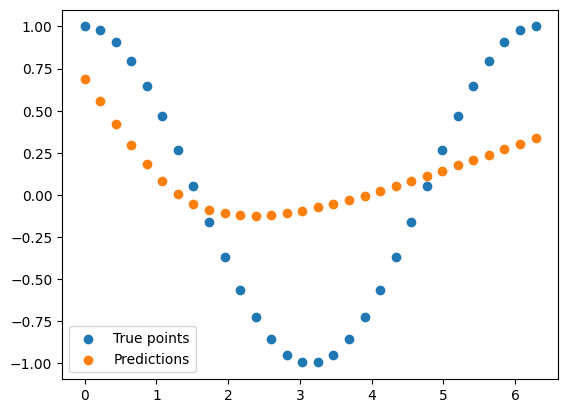

Avg loss: 0.307929 

Epoch: 11


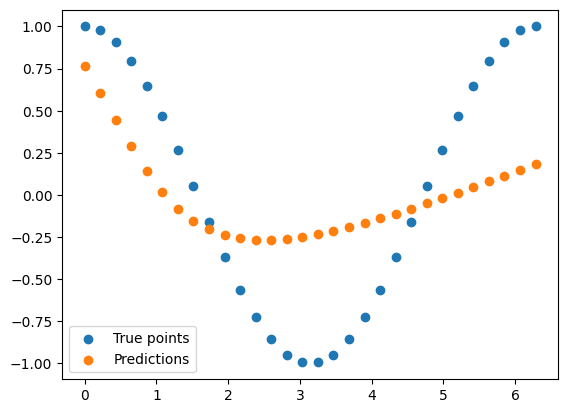

Avg loss: 0.276323 

Epoch: 12


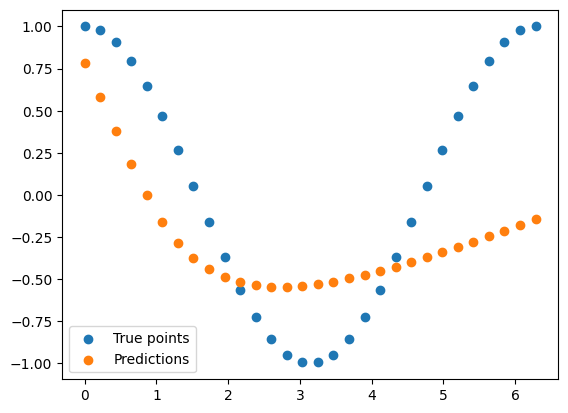

Avg loss: 0.347157 

Epoch: 13


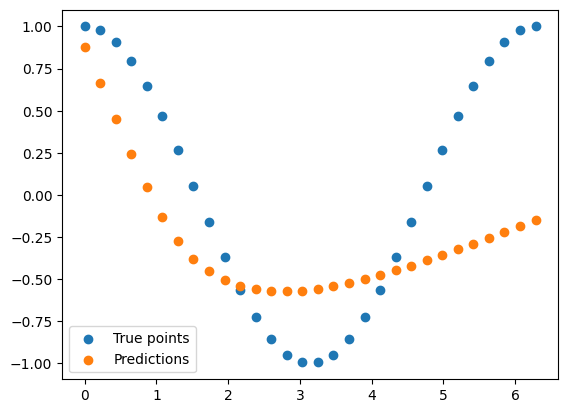

Avg loss: 0.336287 

Epoch: 14


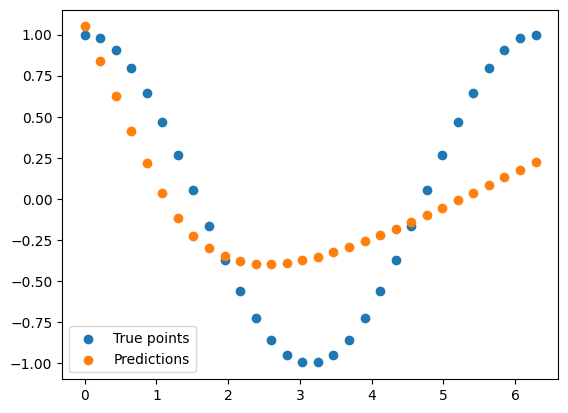

Avg loss: 0.216262 

Epoch: 15


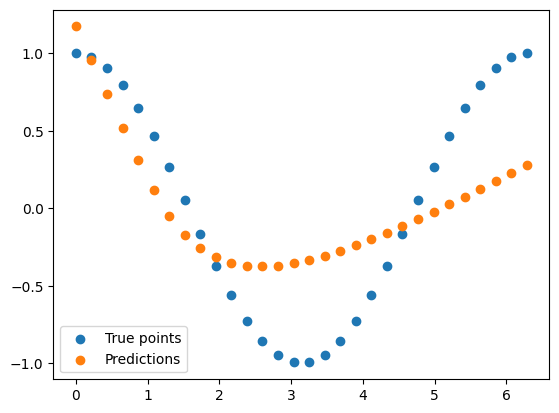

Avg loss: 0.199315 

Epoch: 40


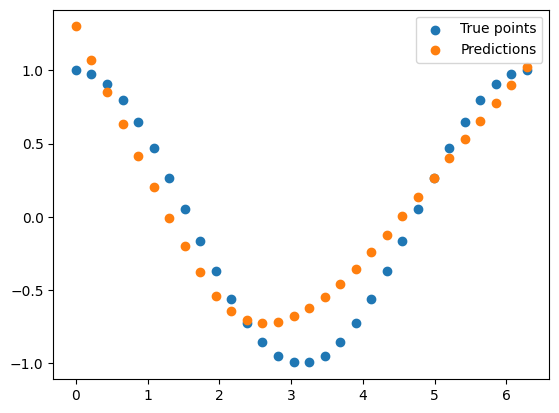

Avg loss: 0.049961 

Epoch: 80


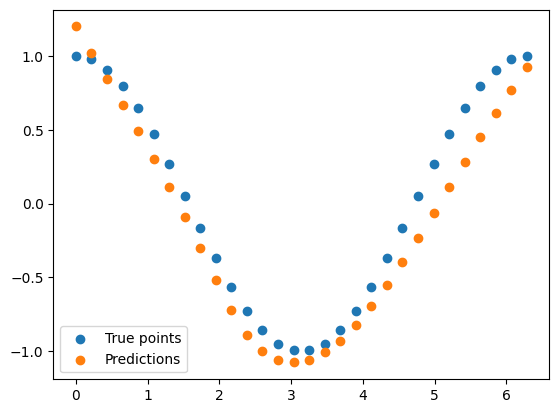

Avg loss: 0.037569 

Epoch: 120


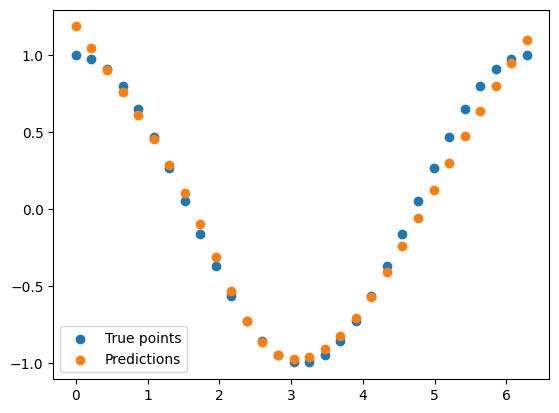

Avg loss: 0.006797 

Epoch: 160


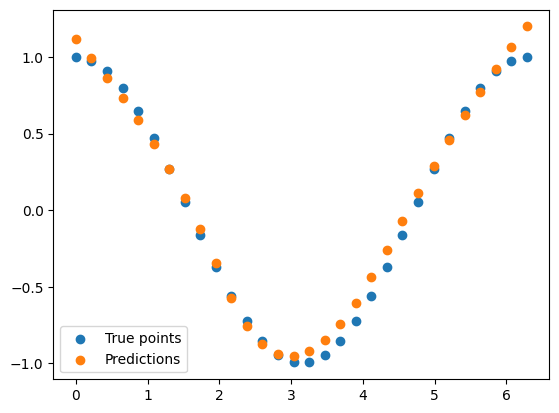

Avg loss: 0.005403 

Epoch: 200


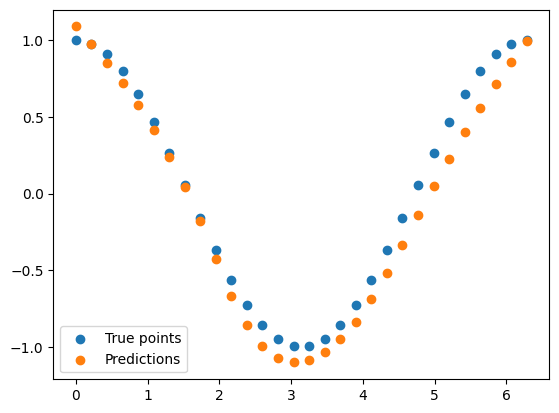

Avg loss: 0.017382 

Done!
Epoch: 1


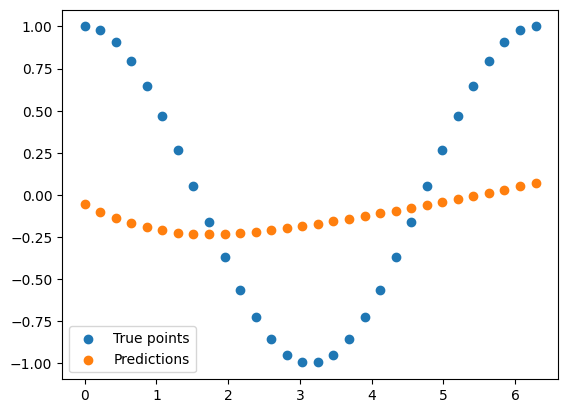

Avg loss: 0.471316 

Epoch: 2


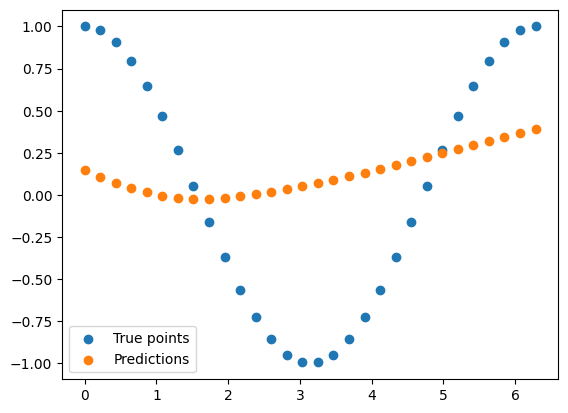

Avg loss: 0.451775 

Epoch: 3


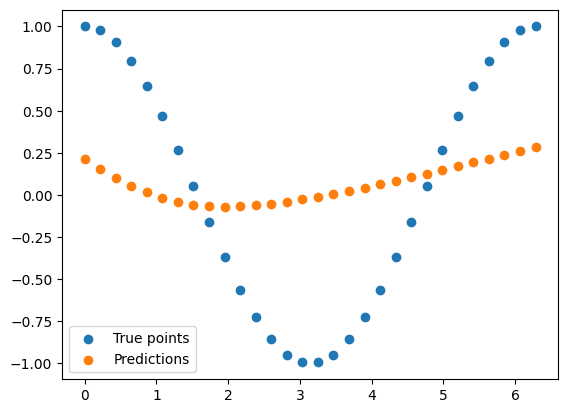

Avg loss: 0.415761 

Epoch: 4


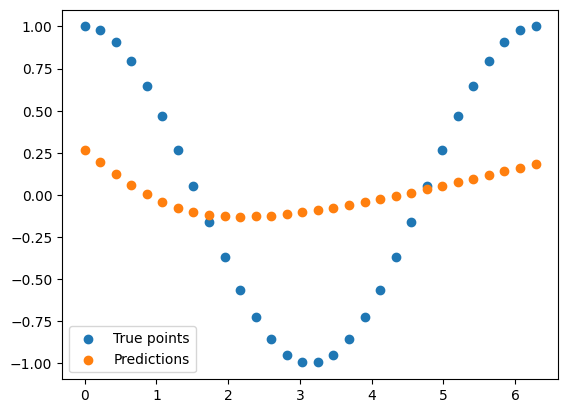

Avg loss: 0.391620 

Epoch: 5


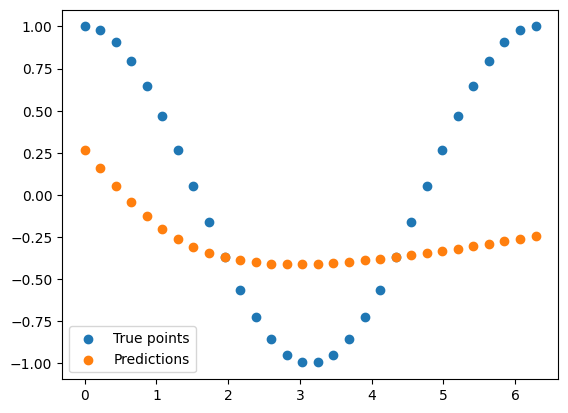

Avg loss: 0.460451 

Epoch: 6


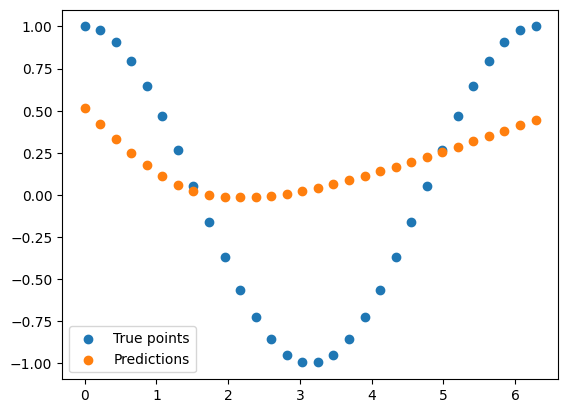

Avg loss: 0.369262 

Epoch: 7


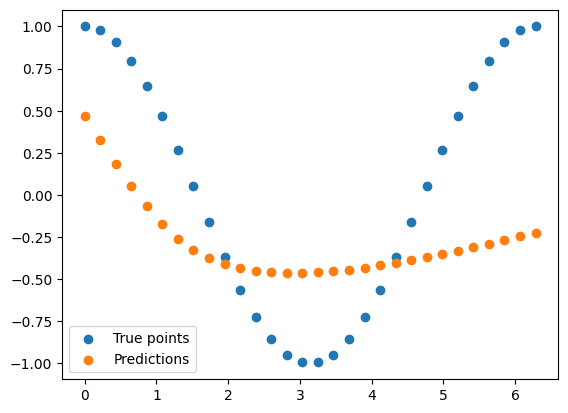

Avg loss: 0.415346 

Epoch: 8


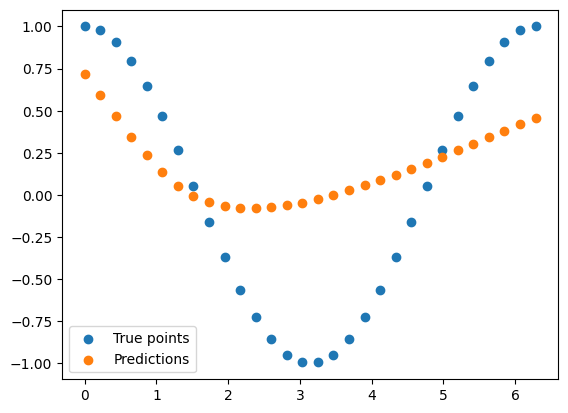

Avg loss: 0.308817 

Epoch: 9


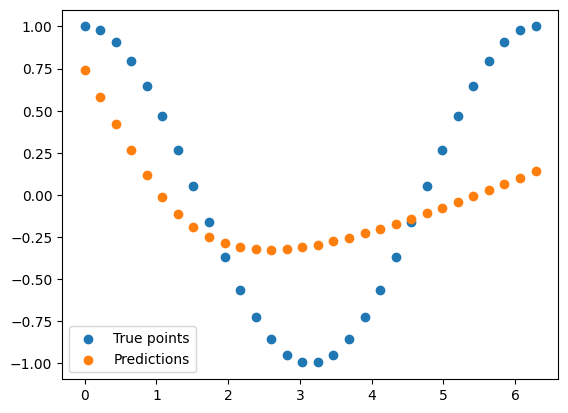

Avg loss: 0.273382 

Epoch: 10


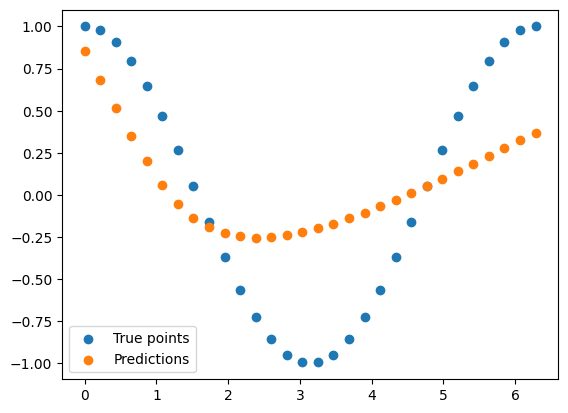

Avg loss: 0.239974 

Epoch: 11


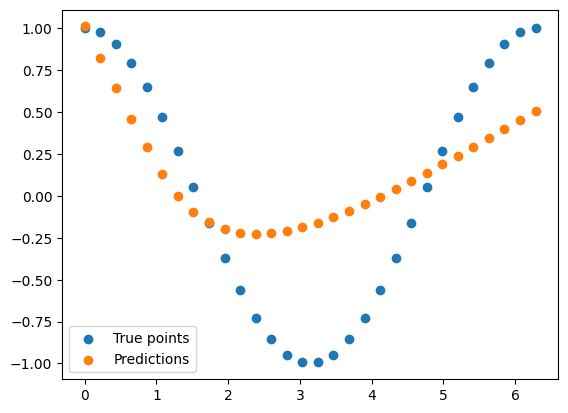

Avg loss: 0.221867 

Epoch: 12


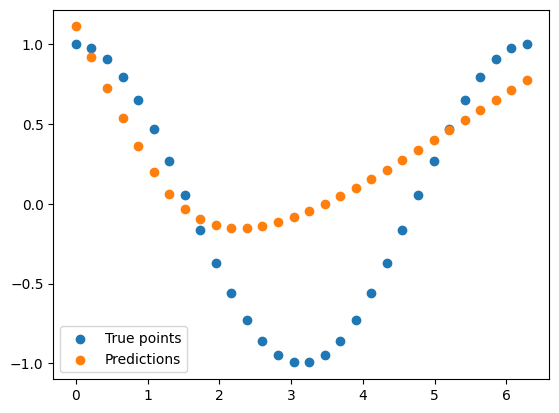

Avg loss: 0.253847 

Epoch: 13


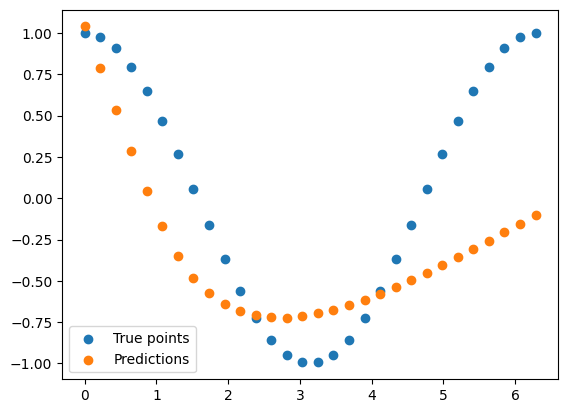

Avg loss: 0.326250 

Epoch: 14


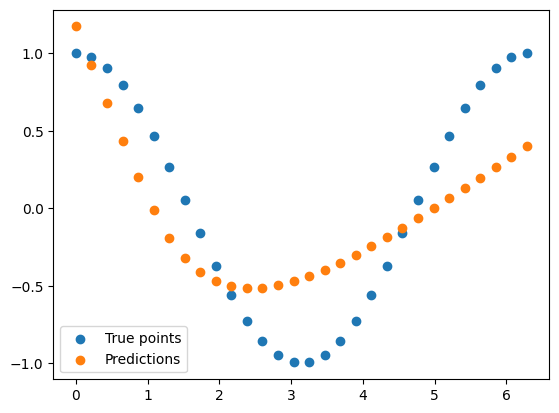

Avg loss: 0.165088 

Epoch: 15


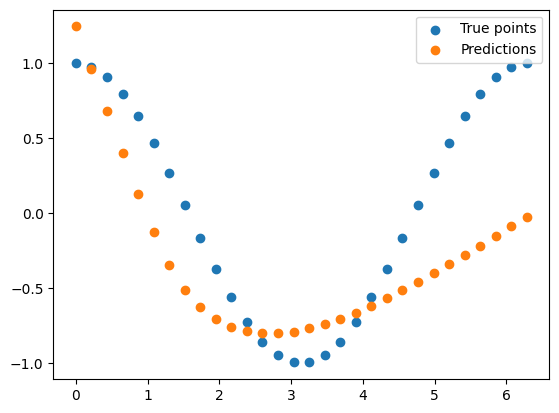

Avg loss: 0.295130 

Epoch: 40


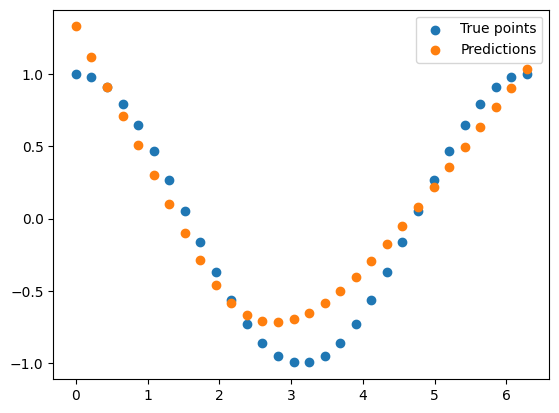

Avg loss: 0.037109 

Epoch: 80


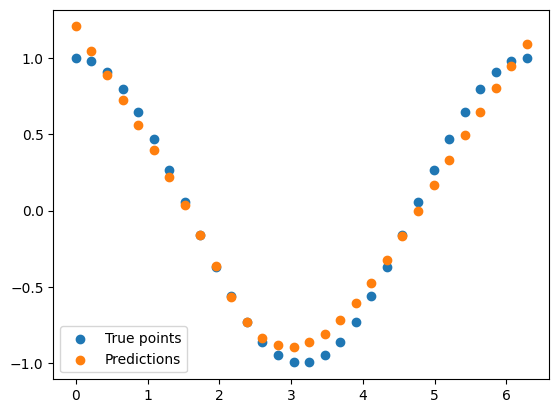

Avg loss: 0.008746 

Epoch: 120


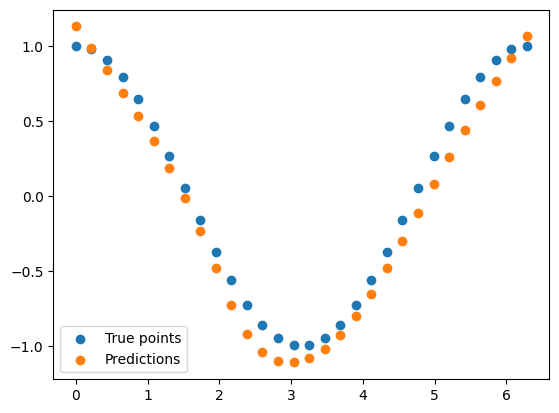

Avg loss: 0.016289 

Epoch: 160


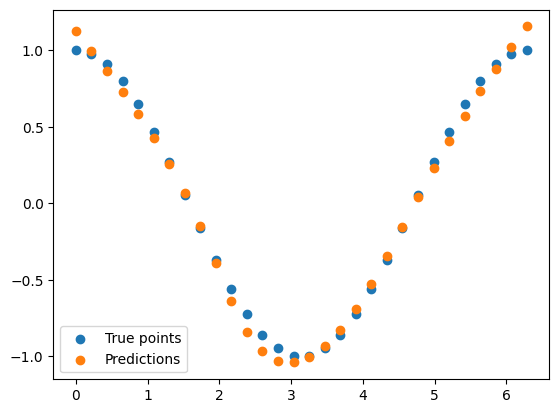

Avg loss: 0.003882 

Epoch: 200


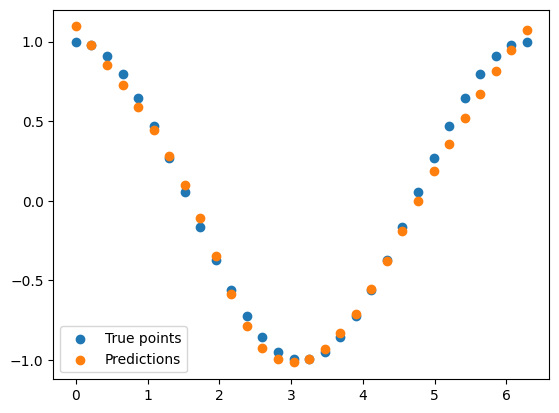

Avg loss: 0.003672 

Done!


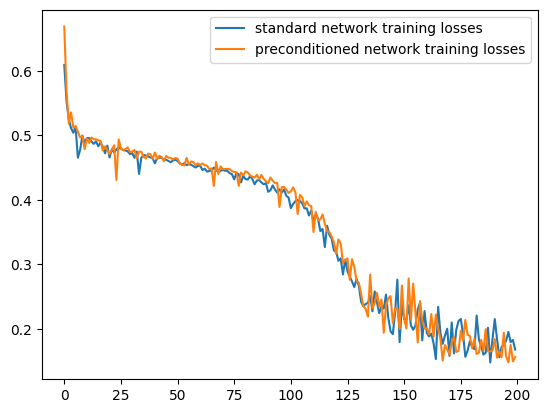

tensor([1.3963])
tensor([5.5851])
tensor([4.1888])
tensor([3.4907])
tensor([2.0944])
tensor([2.7925])
tensor([6.2832])
tensor([0.6981])
tensor([0.])
tensor([4.8869])

tensor([1.3963])
tensor([5.5851])
tensor([4.1888])
tensor([3.4907])
tensor([2.0944])
tensor([2.7925])
tensor([6.2832])
tensor([0.6981])
tensor([0.])
tensor([4.8869])


In [3]:
%run exploration.ipynb

In [32]:
def train_loop_grad_capture(dataloader, model, loss_fn, optimizer, jitter=0):
    size = len(dataloader.dataset)
    total_loss = 0
    batches = 0
    gradients = {}
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X + torch.normal(0, jitter, X.shape))
        loss = loss_fn(pred, y)
        
        loss.backward()

        for name, param in model.named_parameters():
            if name not in gradients:
                gradients[name] = []
            
            if param.grad is not None:
                gradients[name].append(param.grad.clone())
            else:
                print(name)
        
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
        batches += 1
    
    return total_loss / batches, gradients

In [33]:
learning_rate = 1e-2
epochs = 800
train_noise = 0.1

In [34]:
base_gen = Generator()
base_gen.seed()

normal_model = TinyModel()
precond_model = copy.deepcopy(normal_model)

train_dataset = FunctionDataset(torch.sin, 200, stop=2*math.pi, noise=train_noise)
test_dataset = FunctionDataset(torch.sin, 100, stop=2*math.pi, rand_pts=False)


train_gen = Generator().set_state(base_gen.get_state())
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, generator=train_gen)

test_gen = Generator().set_state(base_gen.get_state())
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, generator=test_gen)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(normal_model.parameters(), lr=learning_rate)

Epoch: 1


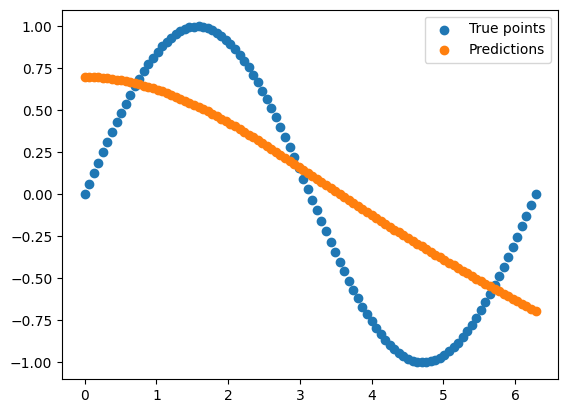

Avg loss: 0.194830 

Epoch: 2


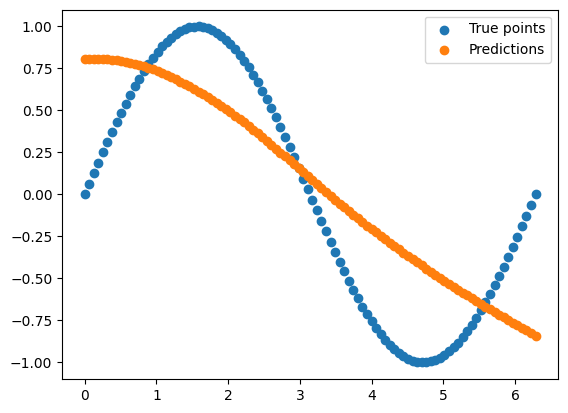

Avg loss: 0.168719 

Epoch: 3


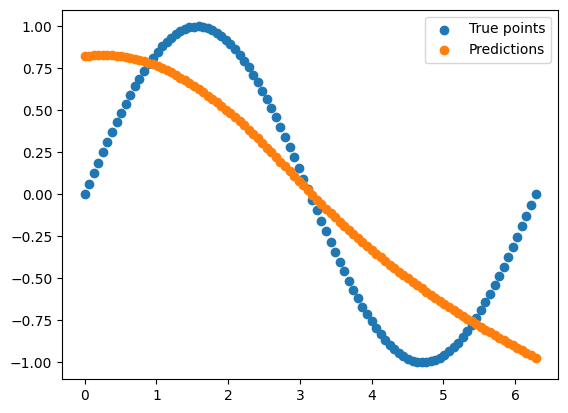

Avg loss: 0.153773 

Epoch: 4


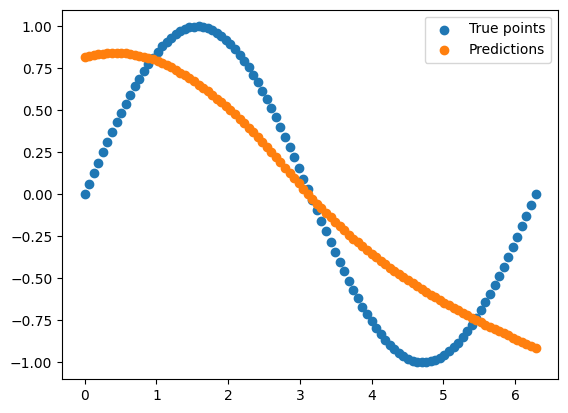

Avg loss: 0.142491 

Epoch: 5


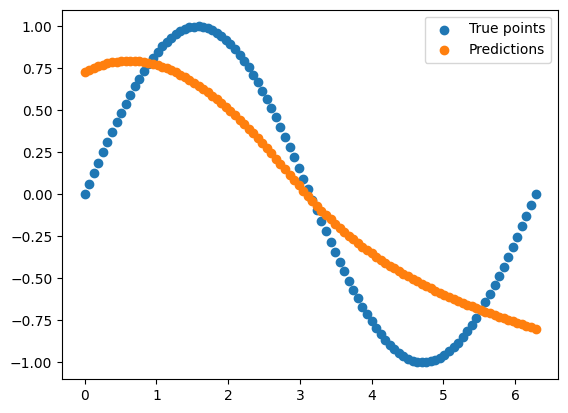

Avg loss: 0.129514 

Epoch: 6


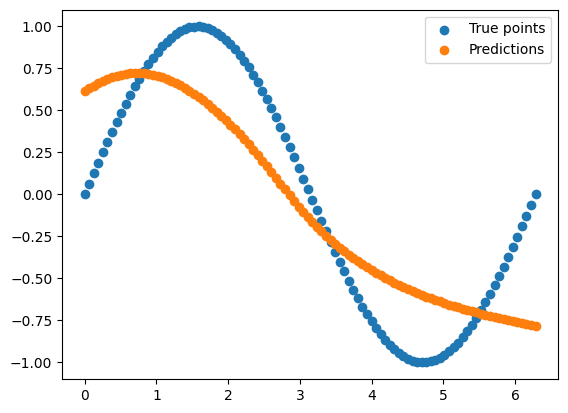

Avg loss: 0.122842 

Epoch: 7


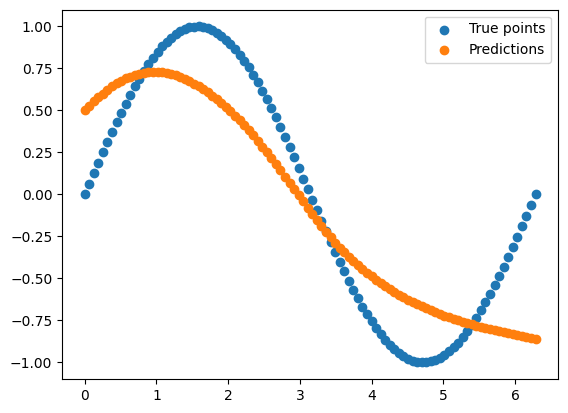

Avg loss: 0.100611 

Epoch: 8


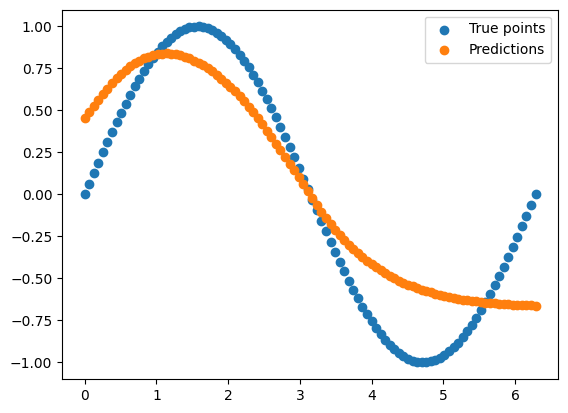

Avg loss: 0.077803 

Epoch: 9


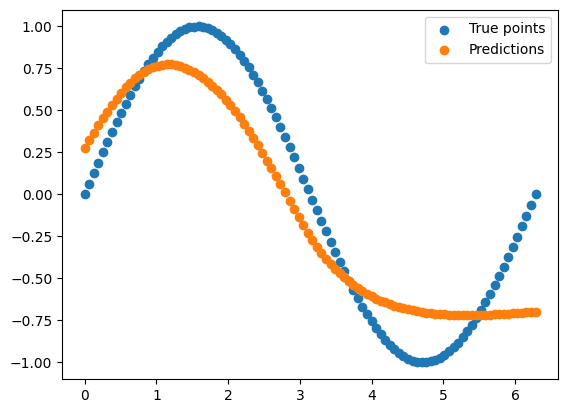

Avg loss: 0.072998 

Epoch: 10


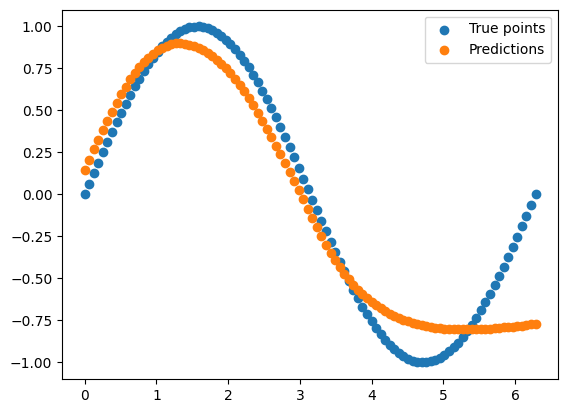

Avg loss: 0.045414 

Epoch: 11


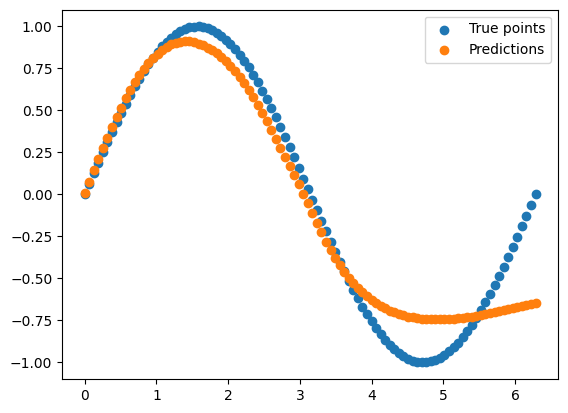

Avg loss: 0.032474 

Epoch: 12


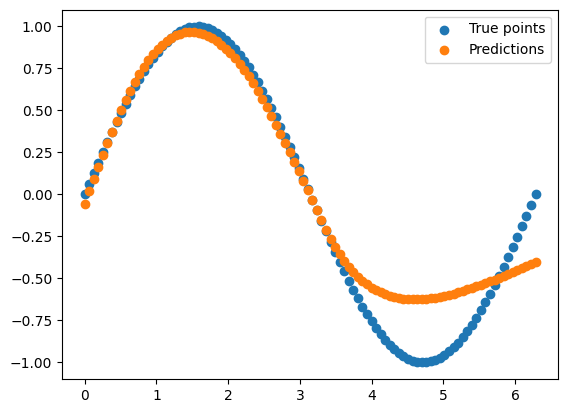

Avg loss: 0.031043 

Epoch: 13


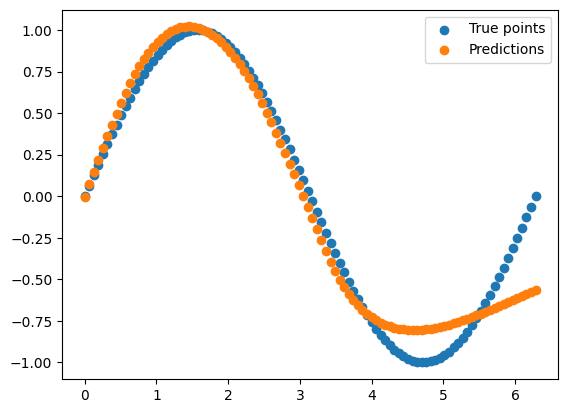

Avg loss: 0.021472 

Epoch: 14


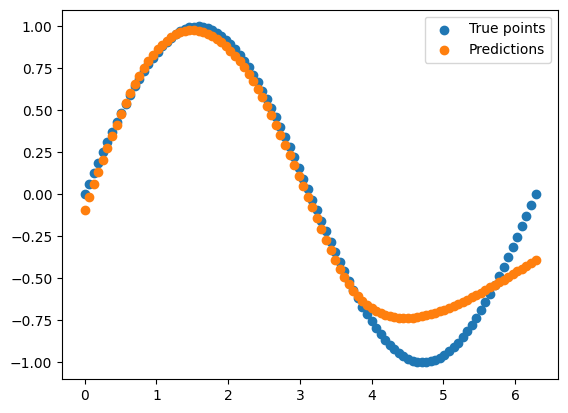

Avg loss: 0.018047 

Epoch: 15


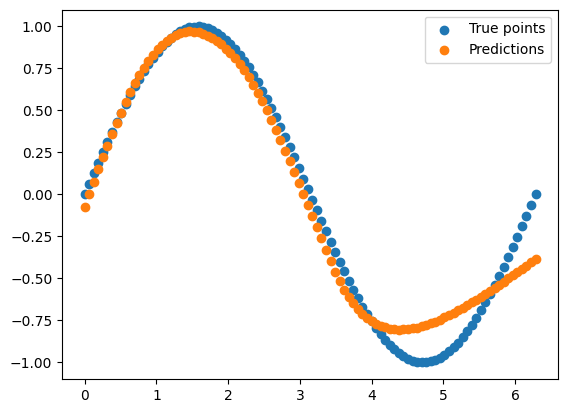

Avg loss: 0.014704 

Epoch: 160


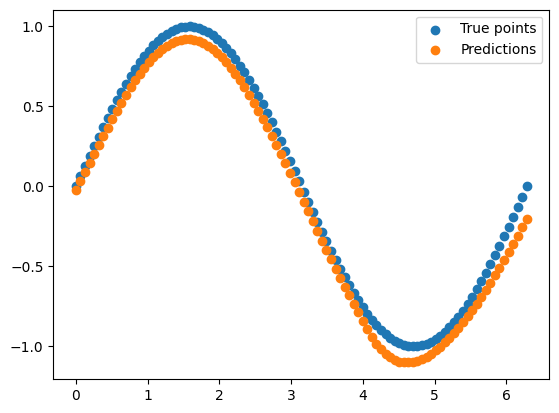

Avg loss: 0.008207 

Epoch: 320


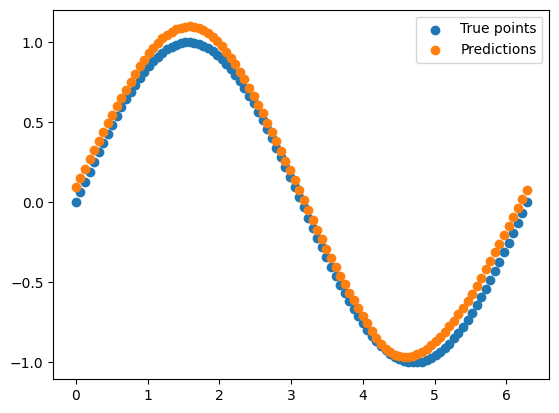

Avg loss: 0.005773 

Epoch: 480


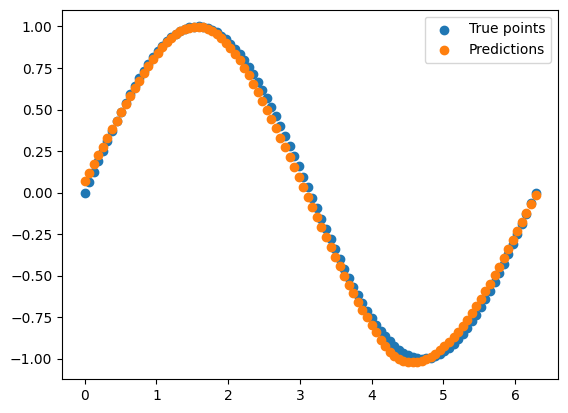

Avg loss: 0.001628 

Epoch: 640


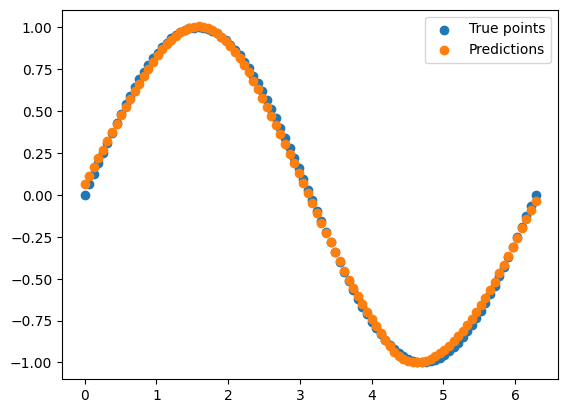

Avg loss: 0.000506 

Epoch: 800


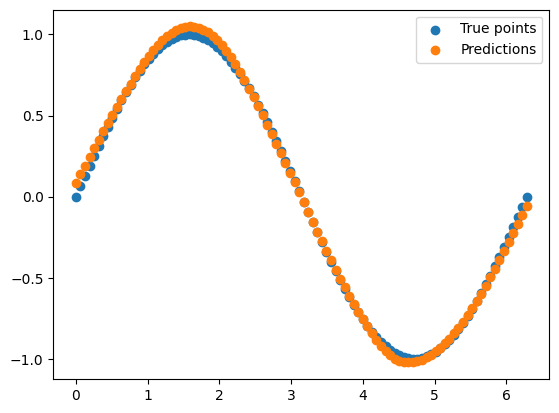

Avg loss: 0.000771 



In [35]:
standard_train_losses = []
grads_per_epoch = []

for t in range(epochs):
    
    avg_loss, gradients = train_loop_grad_capture(train_dataloader, normal_model, loss_function, optimizer)
    standard_train_losses.append(avg_loss)
    grads_per_epoch.append(gradients)
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(test_dataloader, normal_model, loss_function)

In [36]:
keys = [x for x in grads_per_epoch[1].keys()]
print(keys)

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']


In [37]:
def make_grad_lists(grads_per_epoch):
    keys = [x for x in grads_per_epoch[0].keys()]
    combined_grads = {}
    for key in keys:
        combined_grads[key] = []
        
    for i in range(len(grads_per_epoch)):
        for parameter in keys:
            # This concatenation is wrong, they need to be combined along a new, third axis
            # then, later one, we can take the frobenius norm of each set of weights along that third axis
            # i think
            #grads_per_epoch[i][parameter] = torch.linalg.norm(grads_per_epoch[i][parameter])
            combined_grads[parameter].extend(grads_per_epoch[i][parameter])
    return combined_grads


def normed_grad_lists(grad_lists):
    normed_grads = {}
    keys = [x for x in grad_lists.keys()]
    for key in keys:
        normed_grads[key] = []
    for param in keys:
        for gradient in grad_lists[param]:
            normed_grads[param].append(torch.linalg.norm(gradient).item())
    return normed_grads

In [38]:
grad_lists = make_grad_lists(grads_per_epoch)
grad_norm_lists = normed_grad_lists(grad_lists)

In [39]:
keys = [x for x in grad_norm_lists.keys()]
print(keys)
print(len(grad_norm_lists['layers.0.weight']))

['layers.0.weight', 'layers.0.bias', 'layers.2.weight', 'layers.2.bias', 'layers.4.weight', 'layers.4.bias', 'layers.6.weight', 'layers.6.bias']
160000


In [53]:
def plot_grad_norms(grad_norm_lists, key, start_index=0, num_grads=-1):
    if num_grads < 0:
        num_grads =  len(grad_norm_lists[key])
    fig, ax = plt.subplots()
    ax.plot([x for x in range(start_index, start_index + num_grads)], grad_norm_lists[key][start_index:start_index+num_grads], label=key)
    ax.legend()

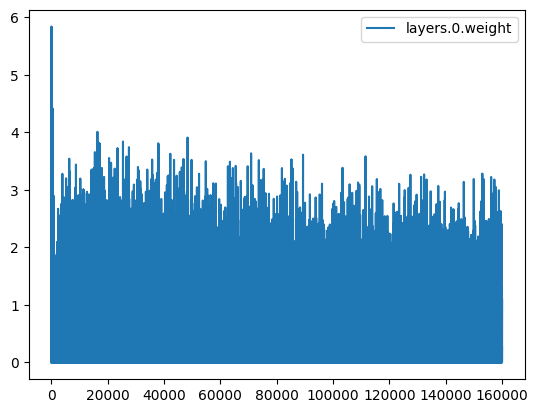

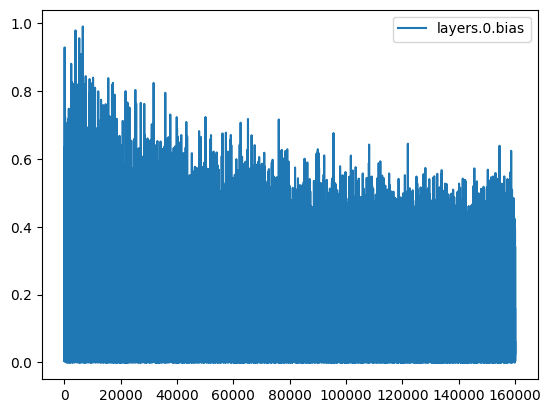

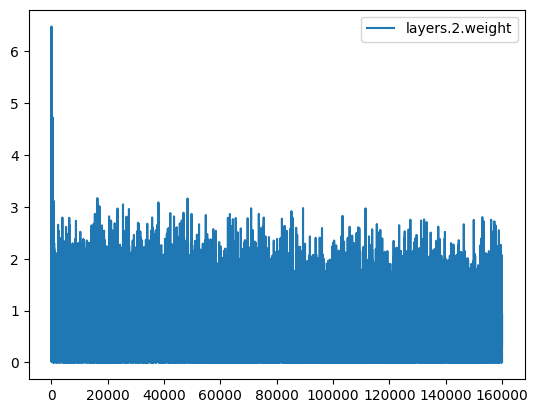

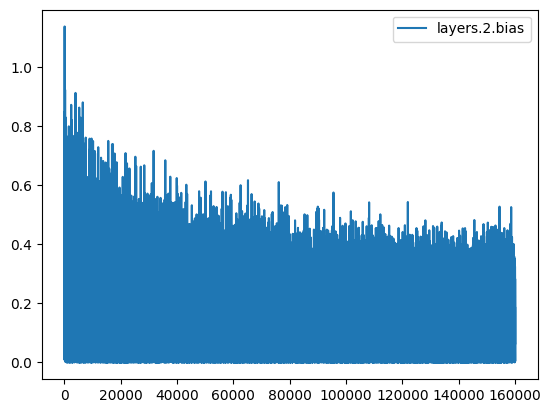

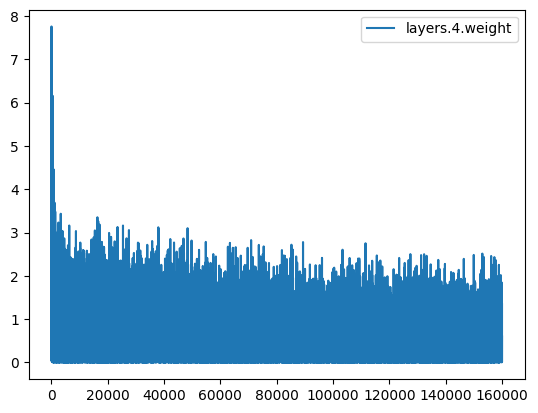

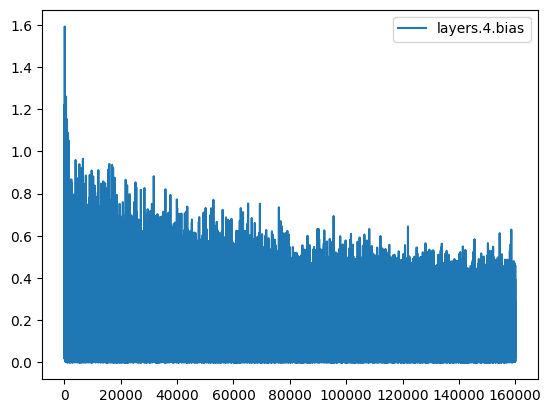

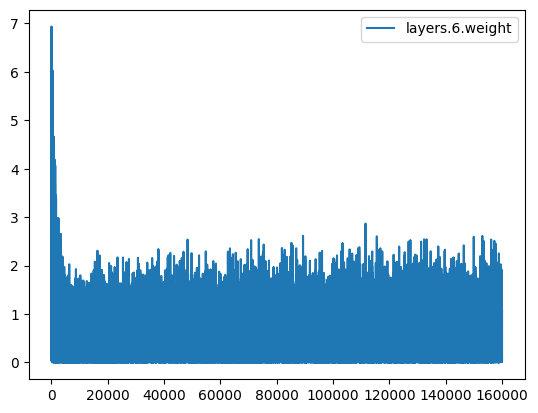

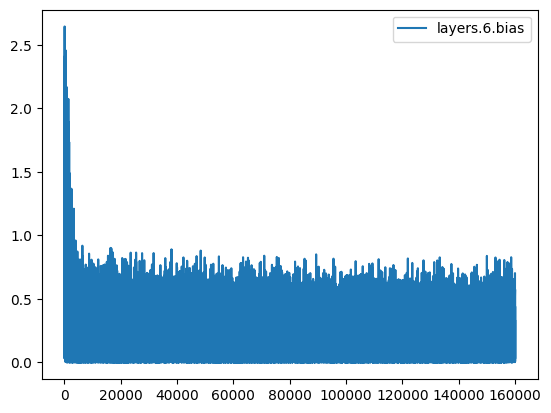

In [54]:
for key in keys:
    plot_grad_norms(grad_norm_lists, key)

In [41]:
grad_series = {}
for key in grad_norm_lists.keys():
    grad_series[key] = pd.Series(grad_norm_lists[key])

for key in grad_series.keys():
    print("parameter: ", key)
    print(grad_series[key].describe())
    print()

parameter:  layers.0.weight
count    160000.000000
mean          0.361758
std           0.438063
min           0.000000
25%           0.066856
50%           0.195389
75%           0.497759
max           5.838557
dtype: float64

parameter:  layers.0.bias
count    1.600000e+05
mean     1.177003e-01
std      1.032449e-01
min      4.170330e-07
25%      3.769285e-02
50%      9.240774e-02
75%      1.684437e-01
max      9.911324e-01
dtype: float64

parameter:  layers.2.weight
count    1.600000e+05
mean     3.383488e-01
std      3.504552e-01
min      8.536441e-07
25%      1.050223e-01
50%      2.309946e-01
75%      4.444445e-01
max      6.475852e+00
dtype: float64

parameter:  layers.2.bias
count    1.600000e+05
mean     1.102171e-01
std      9.449073e-02
min      4.121885e-07
25%      3.745278e-02
50%      8.691364e-02
75%      1.577536e-01
max      1.137860e+00
dtype: float64

parameter:  layers.4.weight
count    160000.000000
mean          0.432274
std           0.371228
min           0.000

In [42]:
# Pretraining:
precond_epochs = 500
precond_prime = TinyModel()

precond_lr = 1e-3
precond_optimizer = torch.optim.SGD(precond_model.parameters(), lr=precond_lr)

precond_losses = []
precond_training_losses = []

pre_train_gen = Generator().set_state(base_gen.get_state())
pre_train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, generator=pre_train_gen)

pre_test_gen = Generator().set_state(base_gen.get_state())
pre_test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, generator=pre_test_gen)

Epoch: 1


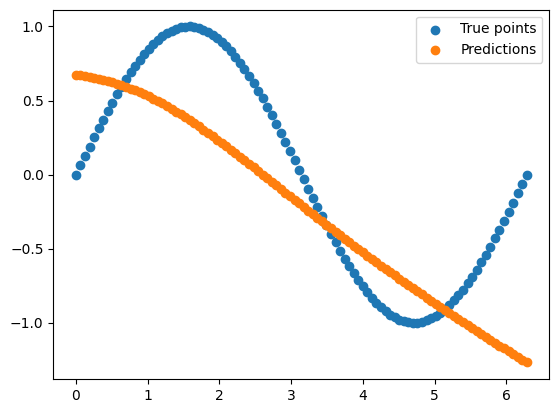

Avg loss: 0.227136 

Epoch: 2


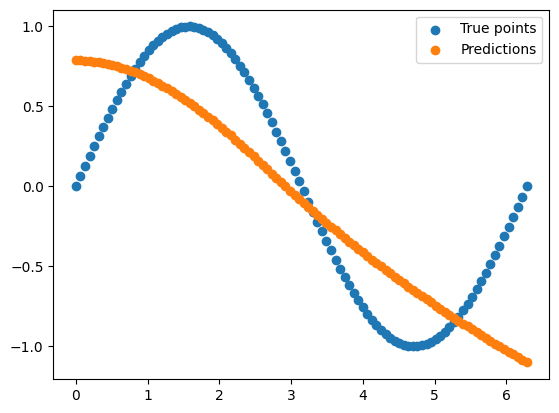

Avg loss: 0.174981 

Epoch: 3


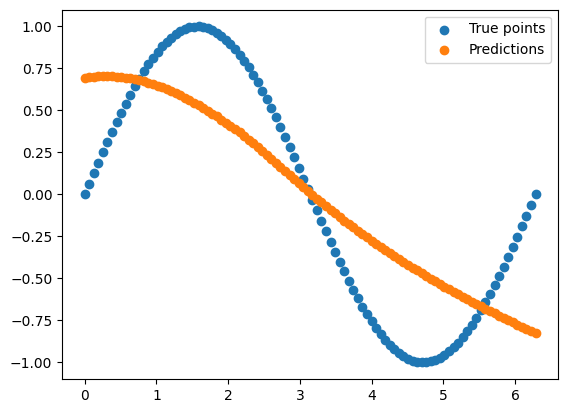

Avg loss: 0.158326 

Epoch: 4


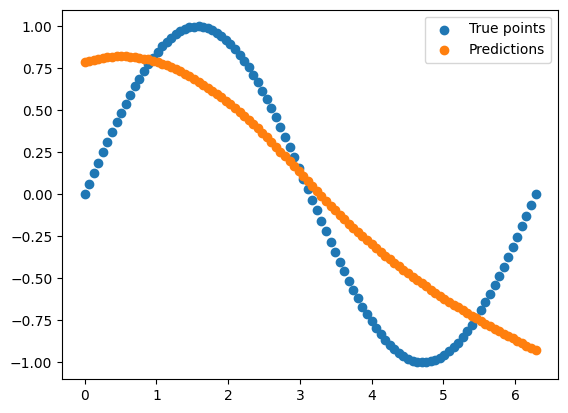

Avg loss: 0.145729 

Epoch: 5


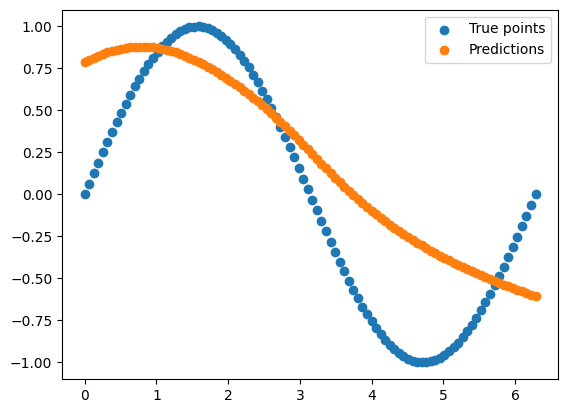

Avg loss: 0.179901 

Epoch: 6


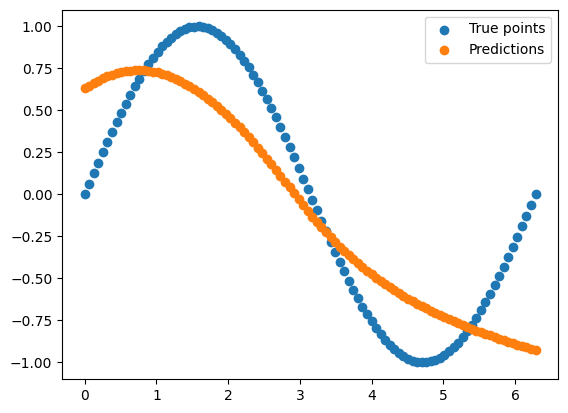

Avg loss: 0.122704 

Epoch: 7


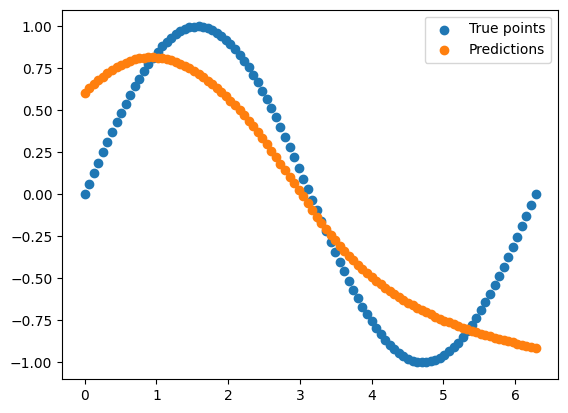

Avg loss: 0.102009 

Epoch: 8


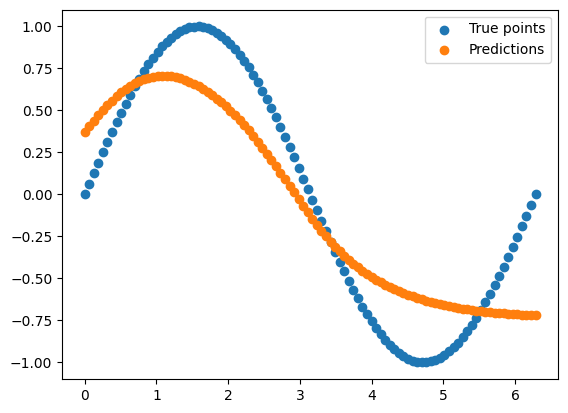

Avg loss: 0.086974 

Epoch: 9


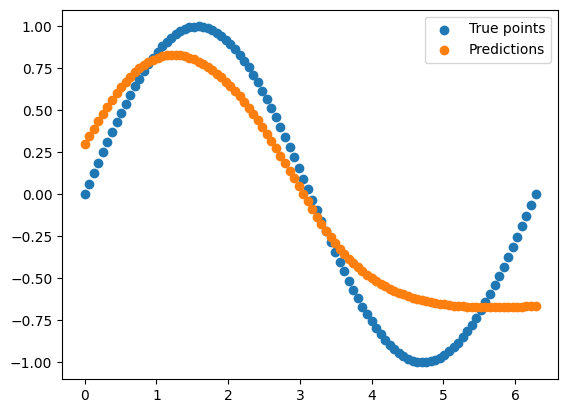

Avg loss: 0.060010 

Epoch: 10


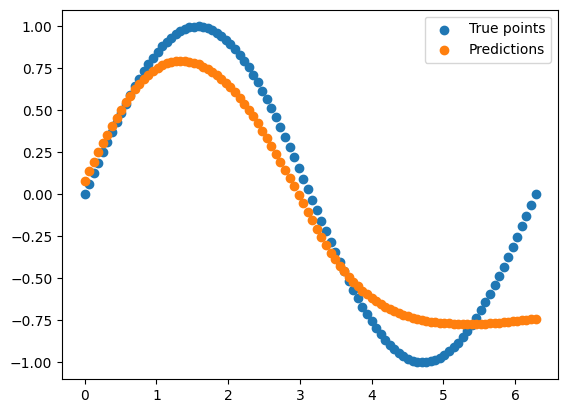

Avg loss: 0.051581 

Epoch: 11


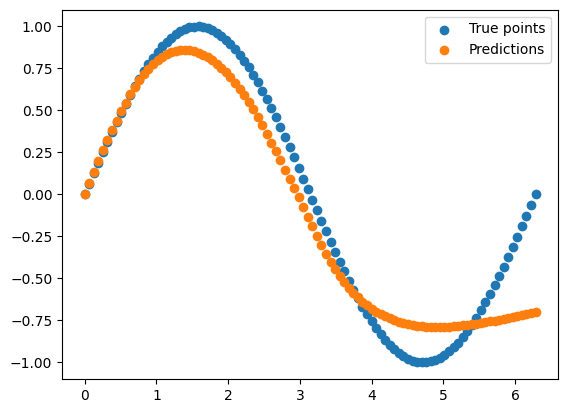

Avg loss: 0.040430 

Epoch: 12


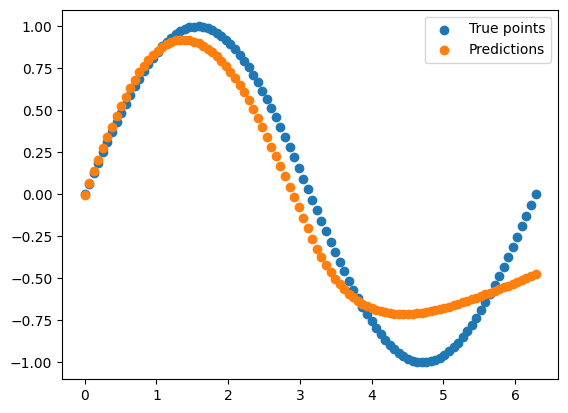

Avg loss: 0.034344 

Epoch: 13


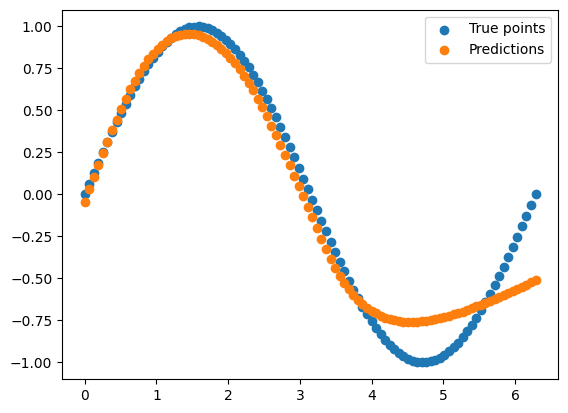

Avg loss: 0.021916 

Epoch: 14


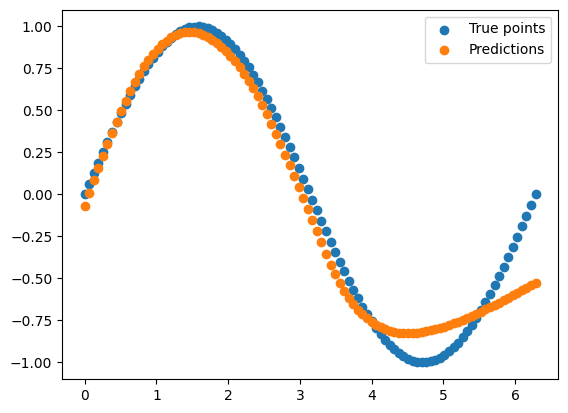

Avg loss: 0.019476 

Epoch: 15


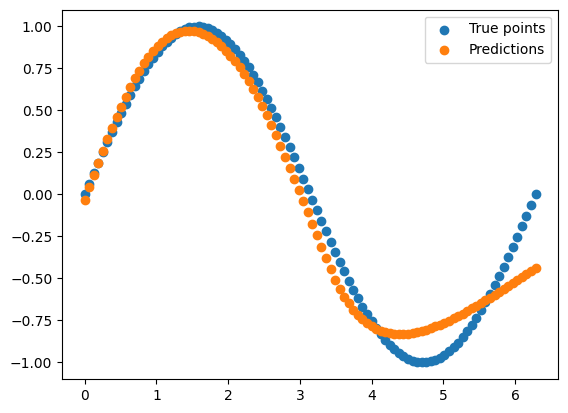

Avg loss: 0.016980 

Epoch: 160


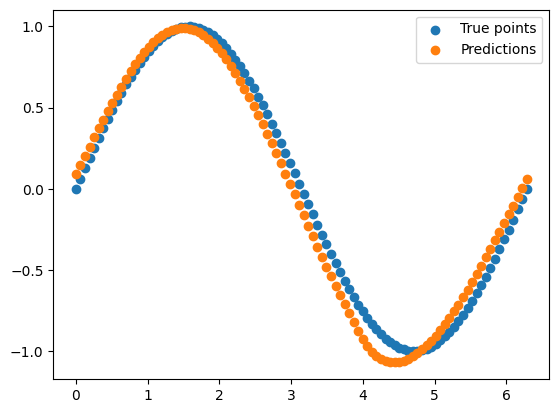

Avg loss: 0.009367 

Epoch: 320


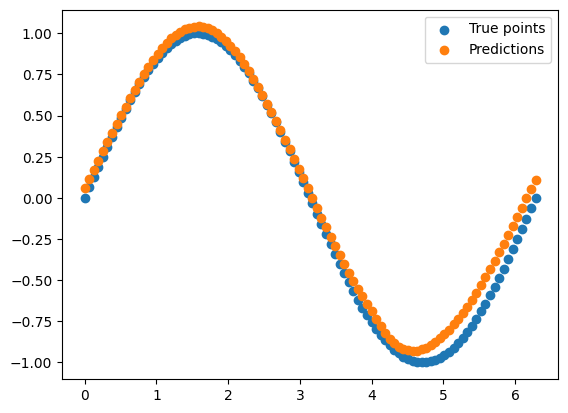

Avg loss: 0.005954 

Epoch: 480


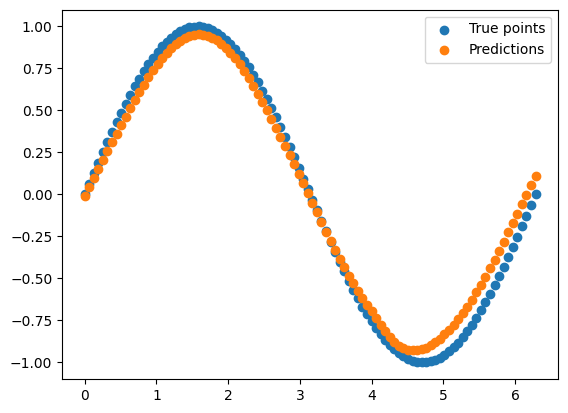

Avg loss: 0.006744 

Epoch: 640


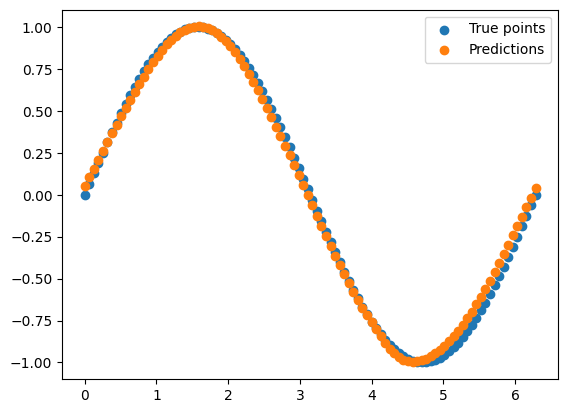

Avg loss: 0.001600 

Epoch: 800


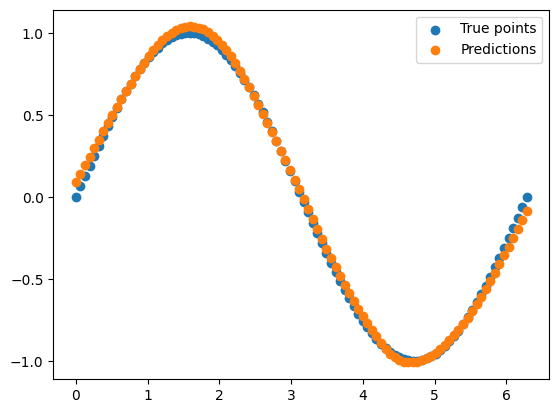

Avg loss: 0.000891 



In [43]:
for t in range(precond_epochs):
    precond_losses.append(precond_loop(precond_model, precond_prime, pre_train_dataloader, nbd_loss, precond_optimizer))

training_optimizer = torch.optim.SGD(precond_model.parameters(), lr=learning_rate)
prec_train_losses = []
prec_grads_per_epoch = []

for t in range(epochs):
    
    avg_loss, grads = train_loop_grad_capture(pre_train_dataloader, precond_model, loss_function, training_optimizer)
    prec_train_losses.append(avg_loss)
    prec_grads_per_epoch.append(grads)
    
    if (t + 1) < 16 or (t+1) % int(.2 * epochs) == 0:
        print(f"Epoch: {t+1}")
        test_loop(pre_test_dataloader, precond_model, loss_function)

In [49]:
p_grad_lists = make_grad_lists(grads_per_epoch)
p_grad_norm_lists = normed_grad_lists(grad_lists)

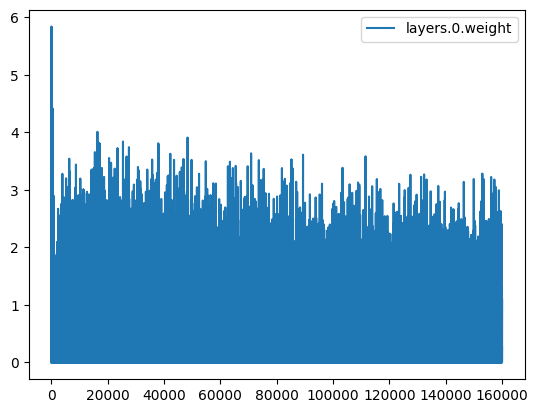

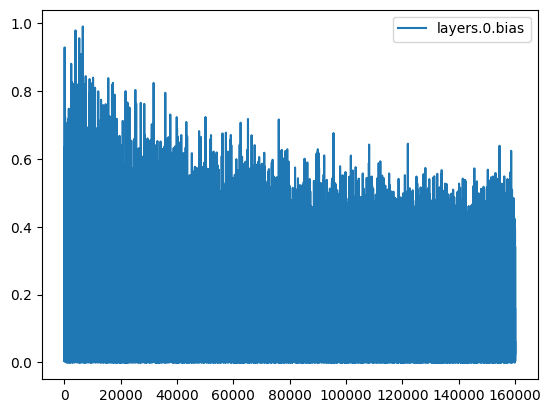

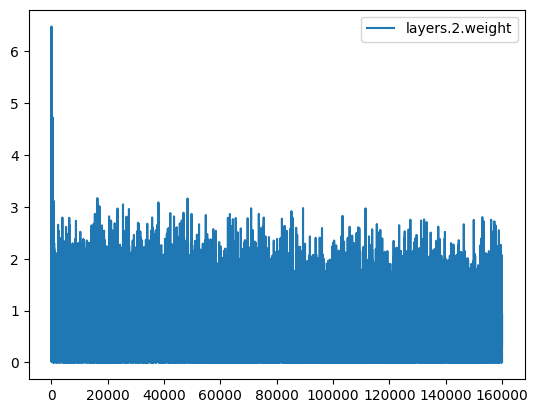

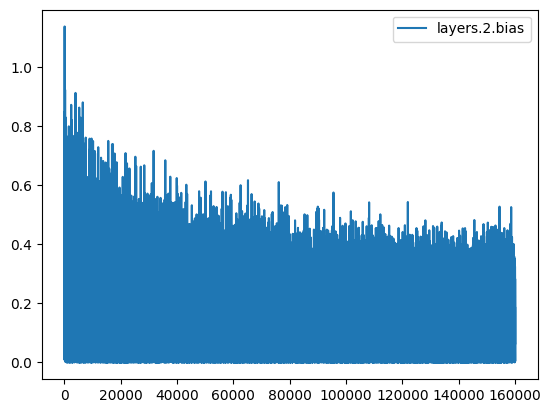

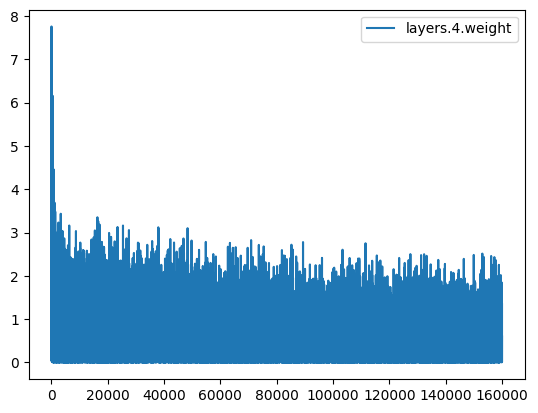

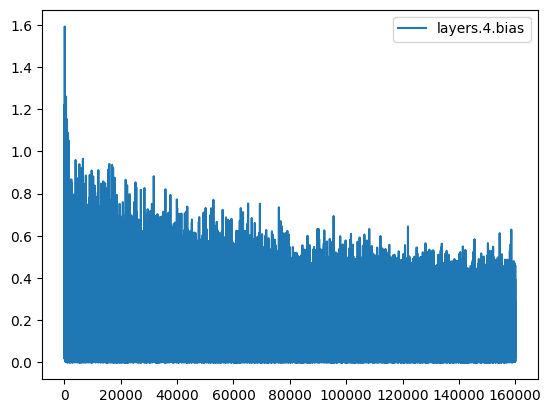

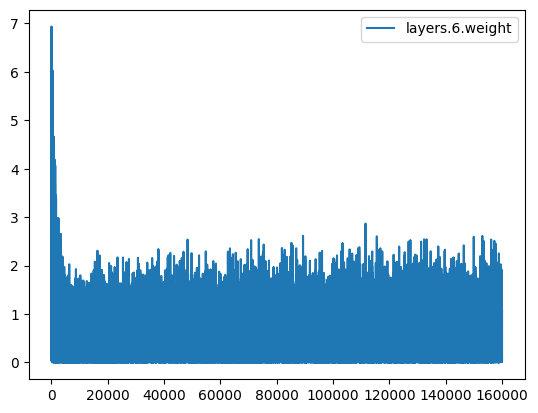

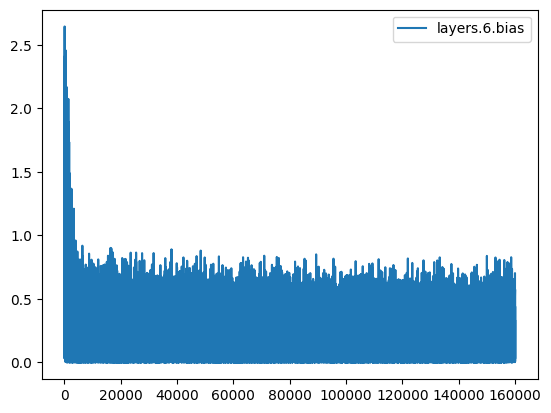

In [50]:
for key in keys:
    plot_grad_norms(p_grad_norm_lists, key)

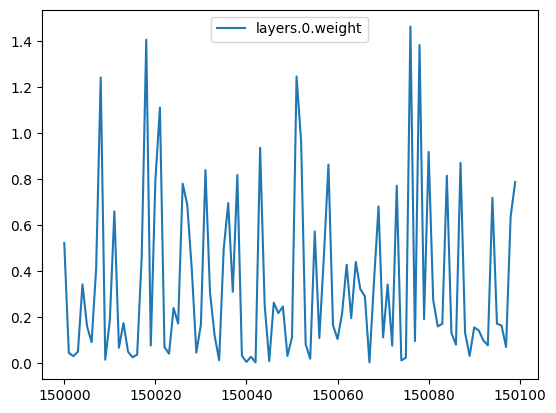

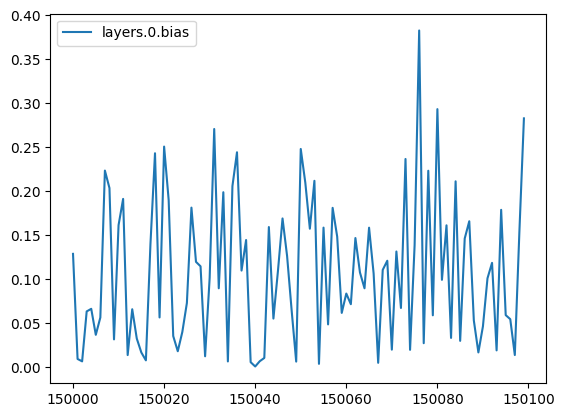

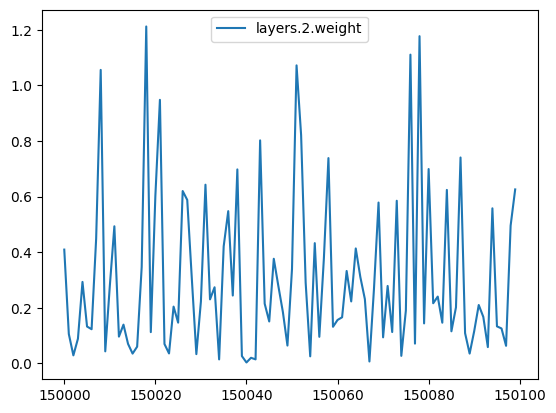

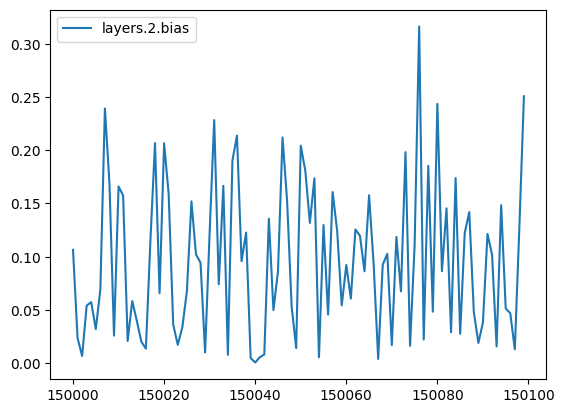

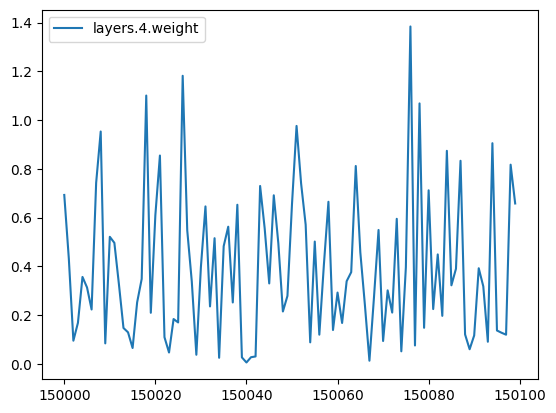

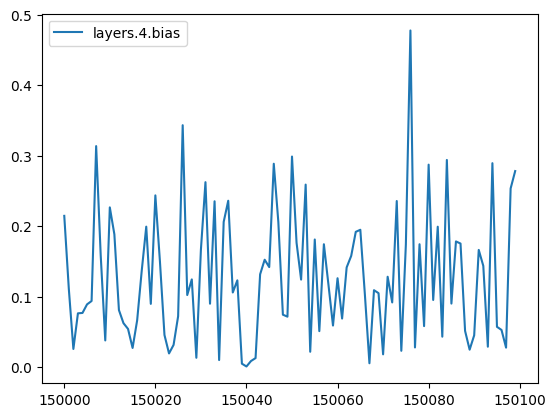

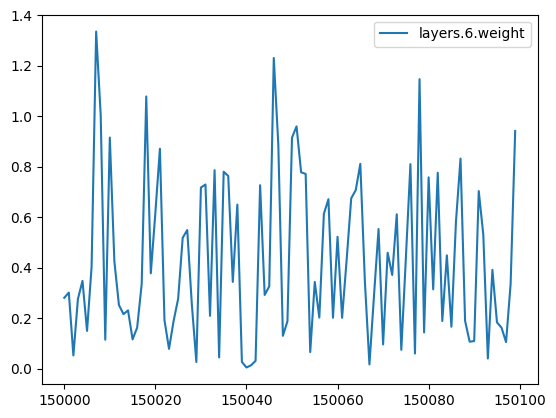

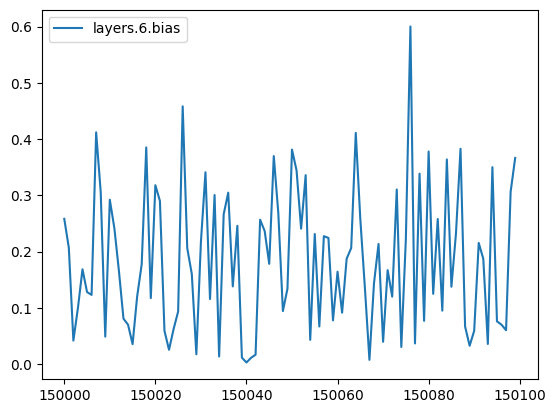

In [64]:
for key in keys:
    plot_grad_norms(p_grad_norm_lists, key, start_index=150000, num_grads=100)